# Análise de variância (ANOVA) - Preços de imóveis

## Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from itertools import zip_longest
import scipy.stats as stats
import statsmodels.formula.api as smf
import scikit_posthocs as sp
import numpy as np

sns.set_theme(style="whitegrid", palette="pastel")

## Análise exploratória

### Análise inicial

In [2]:
df = pd.read_csv('AmesHousing.csv')

In [3]:
print('Número de linhas:', len(df))

Número de linhas: 2930


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [5]:
df.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  
1        0       6    2010       WD           Normal     105000  
2    12500       6    2010       WD           Normal     172000  
3        0       4    2010       WD           Normal     244000  
4        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

In [6]:
print('Número de features:', len(df.drop(columns=['SalePrice']).columns))

Número de features: 81


In [7]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print('Valores faltantes ou iguais a zero')
missing_values.sort_values(ascending=False)

Valores faltantes ou iguais a zero


Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Qual        159
Garage Cond        159
Garage Yr Blt      159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
BsmtFin SF 1         1
BsmtFin SF 2         1
Electrical           1
Total Bsmt SF        1
Bsmt Unf SF          1
Garage Area          1
Garage Cars          1
dtype: int64

### Descrição das features

De acordo com a [documentação](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt) apresentada no [artigo original](https://jse.amstat.org/v19n3/decock.pdf), as *features* representam o seguinte:

<details open>
  <summary>Variáveis numéricas contínuas (20 variáveis)</summary>

* **Lot Frontage**: Pés lineares da rua conectada à propriedade;
* **Lot Area**: Tamanho do lote em pés quadrados;
* **Mas Vnr Area**: Área do revestimento de alvenaria em pés quadrados;
* **BsmtFin SF 1**: Área acabada do tipo 1 no porão, em pés quadrados.
* **BsmtFin SF 2**: Área acabada do tipo 2 no porão, em pés quadrados;
* **Bsmt Unf SF**: Área não acabada do porão, em pés quadrados;
* **Total Bsmt SF**: Área total do porão, em pés quadrados;
* **1st Flr SF**: Pés quadrados do primeiro andar;
* **2nd Flr SF**: Pés quadrados do segundo andar;
* **Low Qual Fin SF**: Metros quadrados com acabamento de baixa qualidade (todos os andares);
* **Gr Liv Area**: Pés quadrados da área de convivência acima do nível do chão (térreo);
* **Garage Area**: Tamanho da garagem, em pés quadrados;
* **Wood Deck SF**: Área do deck de madeira, em pés quadrados;
* **Open Porch SF**: Área da varanda aberta, em pés quadrados;  
* **Enclosed Porch**: Área da varanda fechada, em pés quadrados;
* **3-Ssn Porch**: Área da varanda para três estações, em pés quadrados;
* **Screen Porch**: Área da varanda com tela, em pés quadrados;
* **Pool Area**: Área da piscina, em pés quadrados;
* **Misc Val**: Valor da _feature_ avulsa;
* **SalePrice**: Preço de venda.
</details>

<details open>
  <summary>Variáveis numéricas discretas (14 variáveis)</summary>
    
* **Order**: Número da observação;
* **Year Built**: Ano de construção;
* **Year Remod/Add**: Ano de remodelação/adição;
* **Bsmt Full Bath**: Bsmt Full Bath;
* **Bsmt Half Bath**: Bsmt Half Bath;
* **Full Bath**: Banheiro completo;
* **Half Bath**: Meio banheiro;
* **Bedroom**: Quarto;
* **Kitchen**: Cozinha;
* **TotRmsAbvGrd**: Total de cômodos acima do nível do solo (não inclui banheiros);
* **Fireplaces**: Número de lareiras;
* **Garage Yr Blt**: Ano de construção da garagem;
* **Garage Cars**: Tamanho da garagem em capacidade de carros;
* **Mo Sold**: Mês da venda (MM);
* **Yr Sold**: Ano da venda (YYYY);
</details>

<details open>
  <summary>Variáveis categóricas nominais (23 variáveis)</summary>

* **PID**: Parcel Identicication Number ("Número de registro" do imóvel);
* **MS SubClass**: Identifica o tipo de residência envolvida na venda:
    - **020**: Casa térrea (1 andar), construções de 1946 em diante, todos os estilos.  
    - **030**: Casa térrea (1 andar), construções de 1945 ou mais antigas.  
    - **040**: Casa térrea (1 andar) com sótão acabado, todas as idades.  
    - **045**: Casa de 1 andar e meio com sótão não acabado, todas as idades.  
    - **050**: Casa de 1 andar e meio com sótão acabado, todas as idades.  
    - **060**: Casa de 2 andares, construções de 1946 em diante.  
    - **070**: Casa de 2 andares, construções de 1945 ou mais antigas.  
    - **075**: Casa de 2 andares e meio, todas as idades.  
    - **080**: Casa de múltiplos níveis ou split-level.  
    - **085**: Casa com entrada split foyer (vestíbulo dividido).  
    - **090**: Duplex (2 unidades), todos os estilos e idades.  
    - **120**: Casa térrea (1 andar) em condomínio planejado (PUD), construções de 1946 em diante.  
    - **150**: Casa de 1 andar e meio em condomínio planejado (PUD), todas as idades.  
    - **160**: Casa de 2 andares em condomínio planejado (PUD), construções de 1946 em diante.  
    - **180**: Condomínio planejado (PUD) de múltiplos níveis, incluindo split-level/split foyer.  
    - **190**: Conversão para residência multifamiliar (2 unidades), todos os estilos e idades.  
* **MS Zoning**: Identifica a classificação geral de zoneamento da venda.
    - **A**: Agricultura.  
    - **C**: Comercial.  
    - **FV**: Residencial de Vila Flutuante.  
    - **I**: Industrial.  
    - **RH**: Residencial de Alta Densidade.  
    - **RL**: Residencial de Baixa Densidade.  
    - **RP**: Residencial de Baixa Densidade com Parque.  
    - **RM**: Residencial de Média Densidade.  
* **Street**: Tipo de acesso rodoviário à propriedade.
    - **Grvl**: Estrada de cascalho.  
    - **Pave**: Estrada pavimentada.  
* **Land Contour**: Nível de planicidade do terreno.
    - **Lvl**: Quase plano/nivelado.  
    - **Bnk**: Em declive — subida rápida e significativa da rua até a construção.  
    - **HLS**: Em encosta — inclinação significativa lateral.  
    - **Low**: Depressão.  
* **Lot Config**: Configuração do lote.
    - **Inside**: Lote interno.  
    - **Corner**: Lote de esquina.  
    - **CulDSac**: Lote em cul-de-sac.  
    - **FR2**: Frente em 2 lados da propriedade.  
    - **FR3**: Frente em 3 lados da propriedade.  
* **Alley**: Tipo de acesso por viela.
    - **Grvl**: Viela de cascalho.  
    - **Pave**: Viela pavimentada.  
    - **NA**: Sem acesso por viela.  
* **Neighborhood**: Localizações físicas dentro dos limites da cidade de Ames.
    - **Blmngtn**: Bloomington Heights.  
    - **Blueste**: Bluestem.  
    - **BrDale**: Briardale.  
    - **BrkSide**: Brookside.  
    - **ClearCr**: Clear Creek.  
    - **CollgCr**: College Creek.  
    - **Crawfor**: Crawford.  
    - **Edwards**: Edwards.  
    - **Gilbert**: Gilbert.  
    - **Greens**: Greens.  
    - **GrnHill**: Green Hills.  
    - **IDOTRR**: Iowa DOT e ferrovia.  
    - **Landmrk**: Landmark.  
    - **MeadowV**: Meadow Village.  
    - **Mitchel**: Mitchell.  
    - **Names**: North Ames.  
    - **NoRidge**: Northridge.  
    - **NPkVill**: Northpark Villa.  
    - **NridgHt**: Northridge Heights.  
    - **NWAmes**: Northwest Ames.  
    - **OldTown**: Old Town.  
    - **SWISU**: Sul e oeste da Universidade Estadual de Iowa.  
    - **Sawyer**: Sawyer.  
    - **SawyerW**: Sawyer West.  
    - **Somerst**: Somerset.  
    - **StoneBr**: Stone Brook.  
    - **Timber**: Timberland.  
    - **Veenker**: Veenker.  
* **Condition 1**: Proximidade a diversas condições.
    - **Artery**: Próximo a uma rua arterial.  
    - **Feedr**: Próximo a uma rua coletora.  
    - **Norm**: Normal.  
    - **RRNn**: A menos de 200 pés de uma ferrovia norte-sul.  
    - **RRAn**: Ao lado de uma ferrovia norte-sul.  
    - **PosN**: Próximo a característica externa positiva (parque, área verde, etc.).  
    - **PosA**: Ao lado de característica externa positiva.  
    - **RRNe**: A menos de 200 pés de uma ferrovia leste-oeste.  
    - **RRAe**: Ao lado de uma ferrovia leste-oeste.  
* **Condition 2**: Proximidade a diversas condições (quando mais de uma está presente).
    - **Artery**: Próximo a uma rua arterial.  
    - **Feedr**: Próximo a uma rua coletora.  
    - **Norm**: Normal.  
    - **RRNn**: A menos de 200 pés de uma ferrovia norte-sul.  
    - **RRAn**: Ao lado de uma ferrovia norte-sul.  
    - **PosN**: Próximo a característica externa positiva (parque, área verde, etc.).  
    - **PosA**: Ao lado de característica externa positiva.  
    - **RRNe**: A menos de 200 pés de uma ferrovia leste-oeste.  
    - **RRAe**: Ao lado de uma ferrovia leste-oeste.  
* **Bldg Type**: Tipo de residência.
    - **1Fam**: Casa unifamiliar isolada.  
    - **2FmCon**: Conversão para duas famílias (originalmente construída como unifamiliar).  
    - **Duplx**: Duplex.  
    - **TwnhsE**: Casa geminada (unidade de ponta).  
    - **TwnhsI**: Casa geminada (unidade interna).  
* **House Style**: Estilo da residência.
    - **1Story**: Um andar.  
    - **1.5Fin**: Um andar e meio com segundo nível acabado.  
    - **1.5Unf**: Um andar e meio com segundo nível não acabado.  
    - **2Story**: Dois andares.  
    - **2.5Fin**: Dois andares e meio com segundo nível acabado.  
    - **2.5Unf**: Dois andares e meio com segundo nível não acabado.  
    - **SFoyer**: Split foyer (vestíbulo dividido).  
    - **SLvl**: Split level (níveis divididos).
* **Roof Style**: Tipo de telhado.
    - **Flat**: Plano.  
    - **Gable**: Duas águas.  
    - **Gambrel**: Quatro águas (estilo celeiro).  
    - **Hip**: Quatro águas inclinadas.  
    - **Mansard**: Mansarda.  
    - **Shed**: Inclinado.  
* **Roof Matl**: Material do telhado.
    - **ClyTile**: Telha de barro ou cerâmica.  
    - **CompShg**: Telha composta (comum).  
    - **Membran**: Membrana.  
    - **Metal**: Metal.  
    - **Roll**: Telhado de rolo.  
    - **Tar&Grv**: Cascalho e piche.  
    - **WdShake**: Telhas de madeira (rústicas).  
    - **WdShngl**: Telhas de madeira (lisas).  
* **Exterior 1**: Revestimento externo da casa.
    - **AsbShng**: Telhas de amianto.  
    - **AsphShn**: Telhas de asfalto.  
    - **BrkComm**: Tijolo comum.  
    - **BrkFace**: Tijolo aparente.
    - **CBlock**: Bloco de concreto.  
    - **CemntBd**: Placa de cimento.  
    - **HdBoard**: Madeira dura.  
    - **ImStucc**: Estuque imitação.  
    - **MetalSd**: Revestimento metálico.  
    - **Other**: Outro.  
    - **Plywood**: Compensado.  
    - **PreCast**: Pré-moldado.  
    - **Stone**: Pedra.  
    - **Stucco**: Estuque.  
    - **VinylSd**: Revestimento de vinil.  
    - **Wd Sdng**: Revestimento de madeira.  
    - **WdShing**: Telhas de madeira.  
* **Exterior 2**: Revestimento externo adicional da casa (caso haja mais de um material).
    - **AsbShng**: Telhas de amianto.  
    - **AsphShn**: Telhas de asfalto.  
    - **BrkComm**: Tijolo comum.  
    - **BrkFace**: Tijolo aparente.  
    - **CBlock**: Bloco de concreto.  
    - **CemntBd**: Placa de cimento.  
    - **HdBoard**: Madeira dura.  
    - **ImStucc**: Estuque imitação.  
    - **MetalSd**: Revestimento metálico.  
    - **Other**: Outro.  
    - **Plywood**: Compensado.  
    - **PreCast**: Pré-moldado.  
    - **Stone**: Pedra.  
    - **Stucco**: Estuque.  
    - **VinylSd**: Revestimento de vinil.  
    - **Wd Sdng**: Revestimento de madeira.  
    - **WdShing**: Telhas de madeira.  
* **Mas Vnr Type**: Tipo de revestimento de alvenaria.
    - **BrkCmn**: Tijolo comum.  
    - **BrkFace**: Tijolo aparente.  
    - **CBlock**: Bloco de concreto.  
    - **None**: Nenhum.  
    - **Stone**: Pedra.  
* **Heating**: Tipo de aquecimento.
    - **Floor**: Fornalha de piso.  
    - **GasA**: Aquecimento forçado a gás com ar quente.  
    - **GasW**: Aquecimento a gás com água quente ou vapor.  
    - **Grav**: Fornalha de gravidade.  
    - **OthW**: Aquecimento com água quente ou vapor (exceto gás).  
    - **Wall**: Fornalha de parede.  
* **Central Air**: Ar-condicionado central.
    - **N**: Não.  
    - **Y**: Sim.  
* **Garage Type**: Tipo/Localização da garagem.
    - **2Types**: Mais de um tipo de garagem.  
    - **Attchd**: Anexa à casa.  
    - **Basment**: Garagem no porão.  
    - **BuiltIn**: Integrada (parte da casa, geralmente com cômodo acima).  
    - **CarPort**: Cobertura para carro.  
    - **Detchd**: Separada da casa.  
    - **NA**: Sem garagem.  
* **Misc Feature**: Características diversas não cobertas em outras categorias.
    - **Elev**: Elevador.  
    - **Gar2**: Segunda garagem (se não descrita na seção de garagem).  
    - **Othr**: Outra característica.  
    - **Shed**: Galpão (com mais de 100 pés quadrados).  
    - **TenC**: Quadra de tênis.  
    - **NA**: Nenhuma.  
* **Sale Type**: Tipo de venda.
    - **WD**: Escritura de garantia — Venda convencional.  
    - **CWD**: Escritura de garantia — Pagamento à vista.  
    - **VWD**: Escritura de garantia — Financiamento VA (Veterans Affairs).  
    - **New**: Casa recém-construída e vendida.  
    - **COD**: Escritura de oficial judicial/sucessão.  
    - **Con**: Contrato com 15% de entrada e termos regulares.  
    - **ConLw**: Contrato com baixa entrada e baixo juro.  
    - **ConLI**: Contrato com baixo juro.  
    - **ConLD**: Contrato com baixa entrada.  
    - **Oth**: Outro tipo de venda.  
* **Sale Condition**: Condição de venda.
    - **Normal**: Venda normal.  
    - **Abnorml**: Venda anormal (troca, execução hipotecária, venda rápida).  
    - **AdjLand**: Compra de terreno adjacente.  
    - **Alloca**: Alocação — duas propriedades vinculadas com escrituras separadas (ex.: condomínio com unidade de garagem).  
    - **Family**: Venda entre membros da família.  
    - **Partial**: Casa não finalizada quando foi avaliada pela última vez (associada a novas construções).  

</details>

<details open>
  <summary>Variáveis categóricas ordinais (23 variáveis)</summary>
    
* **Lot Shape**: Formato geral do lote.
    - **Reg**: Regular.  
    - **IR1**: Levemente irregular.  
    - **IR2**: Moderadamente irregular.  
    - **IR3**: Irregular.  
* **Utilities**: Tipos de utilidades disponíveis.
    - **AllPub**: Todas as utilidades públicas (Eletricidade, Gás, Água e Esgoto).  
    - **NoSewr**: Eletricidade, Gás e Água (Fossa Séptica).  
    - **NoSeWa**: Apenas Eletricidade e Gás.  
    - **ELO**: Apenas Eletricidade.  
* **Land Slope**: Inclinação do terreno.
    - **Gtl**: Inclinação suave.  
    - **Mod**: Inclinação moderada.  
    - **Sev**: Inclinação acentuada.  
* **Overall Qual**: Avaliação geral dos materiais e acabamentos da casa.
    - **10**: Excelente Superior.  
    - **9**: Excelente.  
    - **8**: Muito Bom.  
    - **7**: Bom.  
    - **6**: Acima da Média.  
    - **5**: Médio.  
    - **4**: Abaixo da Média.  
    - **3**: Regular.  
    - **2**: Ruim.  
    - **1**: Muito Ruim.  
* **Overall Cond**: Avaliação geral da condição da casa.
    - **10**: Excelente Superior.  
    - **9**: Excelente.  
    - **8**: Muito Bom.  
    - **7**: Bom.  
    - **6**: Acima da Média.  
    - **5**: Médio.  
    - **4**: Abaixo da Média.  
    - **3**: Regular.  
    - **2**: Ruim.  
    - **1**: Muito Ruim.  
* **Exter Qual**: Qualidade dos materiais externos.
    - **Ex**: Excelente.  
    - **Gd**: Bom.  
    - **TA**: Médio/Comum.  
    - **Fa**: Regular.  
    - **Po**: Ruim.  
* **Exter Cond**: Condição dos materiais externos.
    - **Ex**: Excelente.  
    - **Gd**: Bom.  
    - **TA**: Médio/Comum.  
    - **Fa**: Regular.  
    - **Po**: Ruim.  
* **Bsmt Qual**: Altura do porão.
    - **Ex**: Excelente (100+ polegadas).  
    - **Gd**: Bom (90-99 polegadas).  
    - **TA**: Típico (80-89 polegadas).  
    - **Fa**: Regular (70-79 polegadas).  
    - **Po**: Ruim (<70 polegadas).  
    - **NA**: Sem porão.  
* **Bsmt Cond**: Condição geral do porão.
    - **Ex**: Excelente.  
    - **Gd**: Bom.  
    - **TA**: Típico (leve umidade permitida).  
    - **Fa**: Regular (umidade ou rachaduras).  
    - **Po**: Ruim (rachaduras severas, afundamento ou umidade).  
    - **NA**: Sem porão.  
* **Bsmt Exposure**: Nível de exposição do porão.
    - **Gd**: Boa exposição.  
    - **Av**: Exposição média.  
    - **Mn**: Exposição mínima.  
    - **No**: Sem exposição.  
    - **NA**: Sem porão.  
* **BsmtFin Type 1**: Classificação da área acabada do porão.
    - **GLQ**: Boas áreas habitáveis.  
    - **ALQ**: Áreas habitáveis médias.  
    - **BLQ**: Áreas habitáveis abaixo da média.  
    - **Rec**: Sala de recreação média.  
    - **LwQ**: Baixa qualidade.  
    - **Unf**: Não finalizado.  
    - **NA**: Sem porão.  
* **BsmtFin Type 2**: Classificação adicional da área acabada do porão.
    - **GLQ**: Boas áreas habitáveis.  
    - **ALQ**: Áreas habitáveis médias.  
    - **BLQ**: Áreas habitáveis abaixo da média.  
    - **Rec**: Sala de recreação média.  
    - **LwQ**: Baixa qualidade.  
    - **Unf**: Não finalizado.  
    - **NA**: Sem porão.  
* **HeatingQC**: Qualidade e condição do aquecimento.
    - **Ex**: Excelente.  
    - **Gd**: Bom.  
    - **TA**: Médio/Comum.  
    - **Fa**: Regular.  
    - **Po**: Ruim.  
* **Electrical**: Sistema elétrico.
    - **SBrkr**: Disjuntores padrão.  
    - **FuseA**: Caixa de fusíveis (60 AMP) com fiação moderna.  
    - **FuseF**: Caixa de fusíveis (60 AMP) com fiação regular.  
    - **FuseP**: Caixa de fusíveis (60 AMP) com fiação antiga.  
    - **Mix**: Misto.  
* **KitchenQual**: Qualidade da cozinha.
    - **Ex**: Excelente.  
    - **Gd**: Bom.  
    - **TA**: Médio/Comum.  
    - **Fa**: Regular.  
    - **Po**: Ruim.  
* **Functional**: Funcionalidade da casa.
    - **Typ**: Funcionalidade típica.  
    - **Min1**: Pequenas deduções 1.  
    - **Min2**: Pequenas deduções 2.  
    - **Mod**: Deduções moderadas.  
    - **Maj1**: Grandes deduções 1.  
    - **Maj2**: Grandes deduções 2.  
    - **Sev**: Danos severos.  
    - **Sal**: Apenas salvamento.  
* **FireplaceQu**: Qualidade da lareira.
    - **Ex**: Excelente (alvenaria excepcional).  
    - **Gd**: Boa (alvenaria no andar principal).  
    - **TA**: Média (lareira pré-fabricada ou alvenaria no porão).  
    - **Fa**: Regular (lareira pré-fabricada no porão).  
    - **Po**: Ruim (fogão Ben Franklin).  
    - **NA**: Sem lareira.  
* **Garage Finish**: Acabamento interno da garagem.
    - **Fin**: Acabamento completo.  
    - **RFn**: Acabamento bruto.  
    - **Unf**: Sem acabamento.  
    - **NA**: Sem garagem.  
* **Garage Qual**: Qualidade da garagem.
    - **Ex**: Excelente.  
    - **Gd**: Boa.  
    - **TA**: Média/Comum.  
    - **Fa**: Regular.  
    - **Po**: Ruim.  
    - **NA**: Sem garagem.  
* **Garage Cond**: Condição da garagem.
    - **Ex**: Excelente.  
    - **Gd**: Boa.  
    - **TA**: Média/Comum.  
    - **Fa**: Regular.  
    - **Po**: Ruim.  
    - **NA**: Sem garagem.  
* **Paved Drive**: Pavimentação da garagem.
    - **Y**: Pavimentada.  
    - **P**: Pavimentação parcial.  
    - **N**: Terra/Gravilha.  
* **Pool QC**: Qualidade da piscina.
    - **Ex**: Excelente.  
    - **Gd**: Boa.  
    - **TA**: Média/Comum.  
    - **Fa**: Regular.  
    - **NA**: Sem piscina.  
* **Fence**: Qualidade da cerca.
    - **GdPrv**: Boa privacidade.  
    - **MnPrv**: Mínima privacidade.  
    - **GdWo**: Boa de madeira.  
    - **MnWw**: Mínima de madeira/arame.  
    - **NA**: Sem cerca.  
</details>

### Ajustes no dado

In [8]:
# Ajustando tipo da coluna com "MS SubClass"

df['MS SubClass'] = df['MS SubClass'].astype(str)

In [9]:
data = df.drop(columns=['Order', 'PID'])

In [10]:
# Removendo identificadores 
features = df.drop(columns=['Order', 'PID', 'SalePrice'])
features.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
0          20        RL         141.0     31770   Pave   NaN       IR1   
1          20        RH          80.0     11622   Pave   NaN       Reg   
2          20        RL          81.0     14267   Pave   NaN       IR1   
3          20        RL          93.0     11160   Pave   NaN       Reg   
4          60        RL          74.0     13830   Pave   NaN       IR1   

  Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC  \
0          Lvl    AllPub     Corner  ...            0         0     NaN   
1          Lvl    AllPub     Inside  ...          120         0     NaN   
2          Lvl    AllPub     Corner  ...            0         0     NaN   
3          Lvl    AllPub     Corner  ...            0         0     NaN   
4          Lvl    AllPub     Inside  ...            0         0     NaN   

   Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  Sale Condition  
0    NaN          NaN        0        5     2010        WD           Normal  
1  MnPrv          NaN        0        6     2010        WD           Normal  
2    NaN         Gar2    12500        6     2010        WD           Normal  
3    NaN          NaN        0        4     2010        WD           Normal  
4  MnPrv          NaN        0        3     2010        WD           Normal  

[5 rows x 79 columns]

In [11]:
target = df['SalePrice']

### Distribuição dos valores de venda

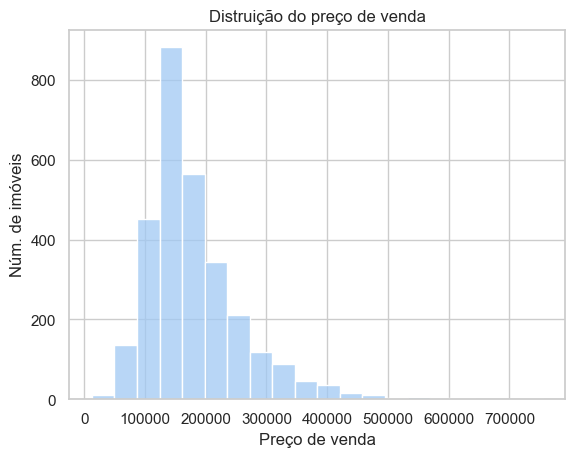

In [12]:
sns.histplot(target, bins=20, kde=False)
plt.xlabel("Preço de venda")
plt.ylabel("Núm. de imóveis")
plt.title("Distruição do preço de venda")
plt.show()

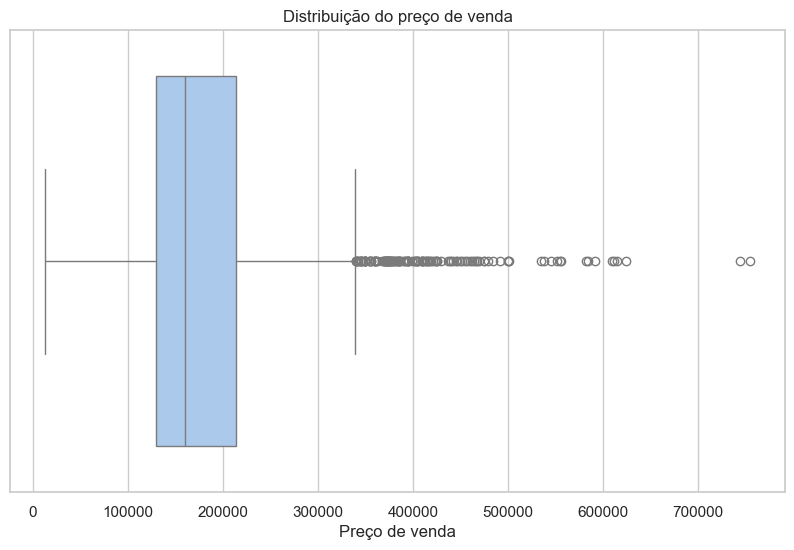

In [13]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=target)

plt.xlabel("Preço de venda")
plt.title("Distribuição do preço de venda")

plt.show()

### Distribuição das variáveis numéricas

In [14]:
numerical_data = features.select_dtypes("number")
numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Lot Frontage     2440 non-null   float64
 1   Lot Area         2930 non-null   int64  
 2   Overall Qual     2930 non-null   int64  
 3   Overall Cond     2930 non-null   int64  
 4   Year Built       2930 non-null   int64  
 5   Year Remod/Add   2930 non-null   int64  
 6   Mas Vnr Area     2907 non-null   float64
 7   BsmtFin SF 1     2929 non-null   float64
 8   BsmtFin SF 2     2929 non-null   float64
 9   Bsmt Unf SF      2929 non-null   float64
 10  Total Bsmt SF    2929 non-null   float64
 11  1st Flr SF       2930 non-null   int64  
 12  2nd Flr SF       2930 non-null   int64  
 13  Low Qual Fin SF  2930 non-null   int64  
 14  Gr Liv Area      2930 non-null   int64  
 15  Bsmt Full Bath   2928 non-null   float64
 16  Bsmt Half Bath   2928 non-null   float64
 17  Full Bath     

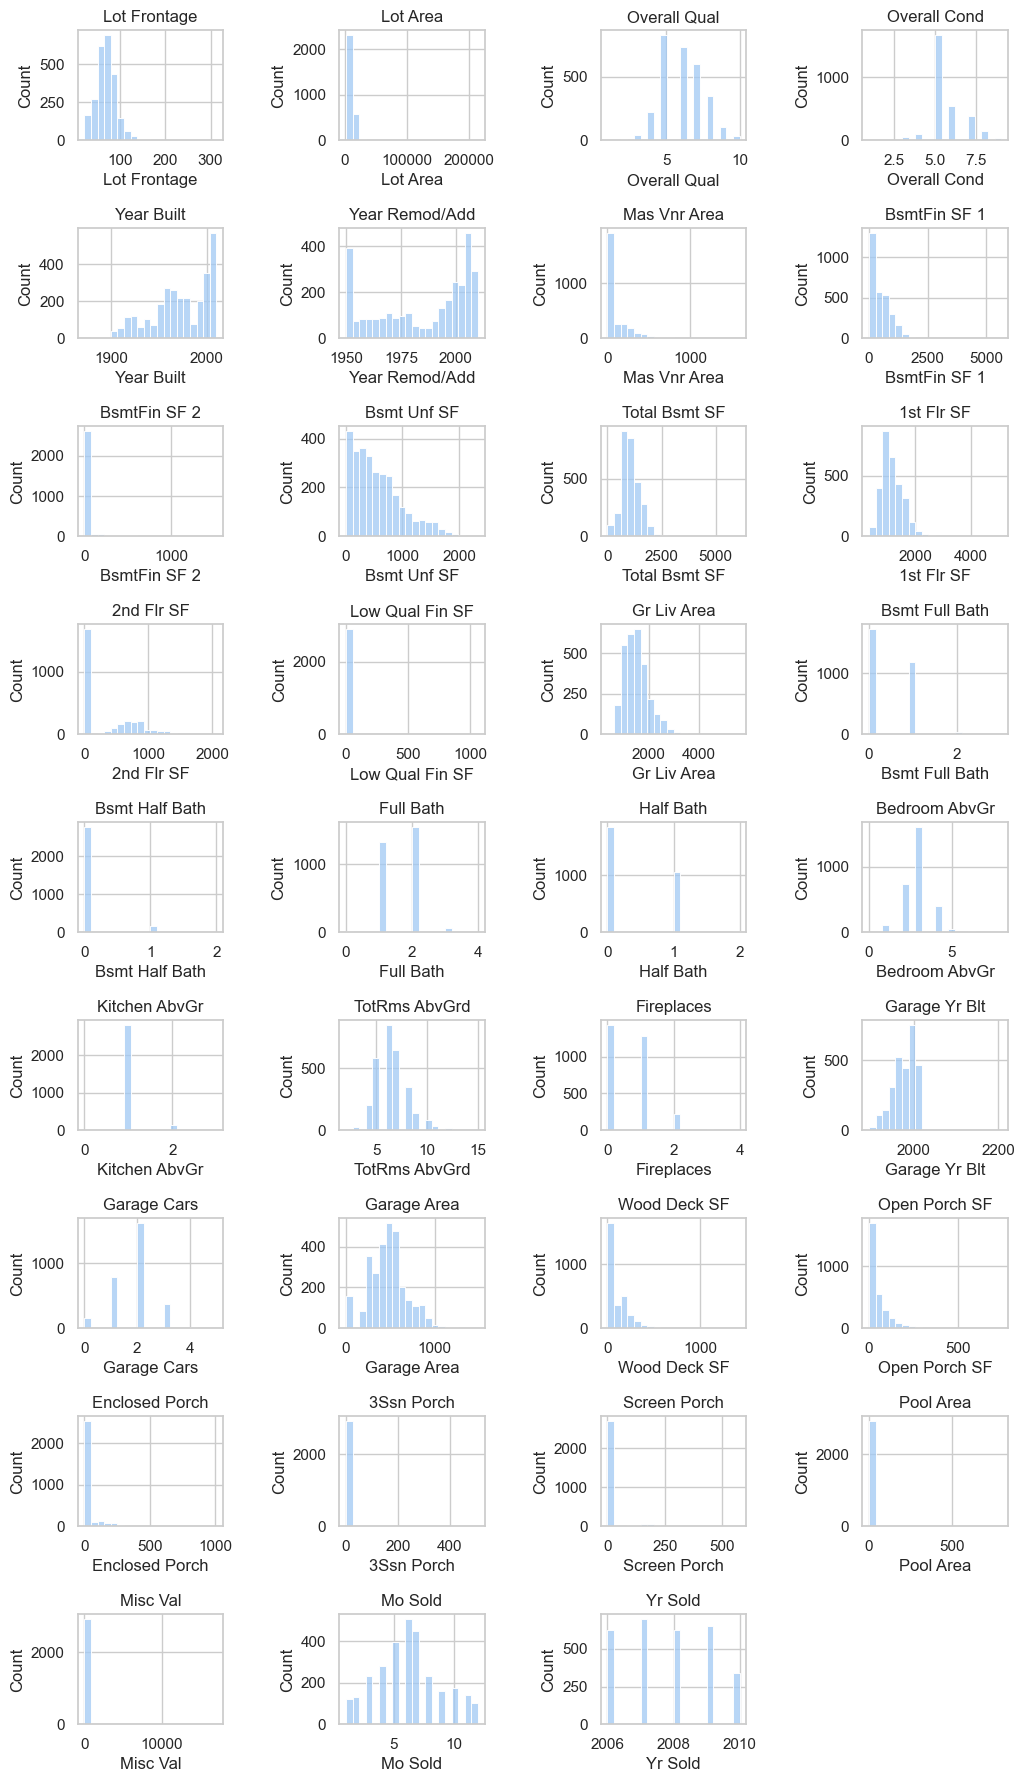

In [15]:
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(12, 22))

axes = axes.flatten()

for i in range(len(numerical_data.columns), 36):
    axes[i].axis('off')
    
for i, column in enumerate(numerical_data.columns):
    sns.histplot(numerical_data[column], bins=20, kde=False, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_title(column)

plt.subplots_adjust(hspace=0.8, wspace=0.8)
plt.show()

Muitas _features_ possuem uma alta contagem de registros com valor 0 ("Pool Area" e "Mas Vnr Area", por exemplo). Isso possivelmente se deve ao fato de imóveis em que esse critério não se aplica. Ou seja, imóveis sem piscina tem área da piscina sendo 0, por exemplo. 

### Distribuição das variáveis categóricas não numéricas

In [16]:
categorical_data = features.select_dtypes(object)
categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MS SubClass     2930 non-null   object
 1   MS Zoning       2930 non-null   object
 2   Street          2930 non-null   object
 3   Alley           198 non-null    object
 4   Lot Shape       2930 non-null   object
 5   Land Contour    2930 non-null   object
 6   Utilities       2930 non-null   object
 7   Lot Config      2930 non-null   object
 8   Land Slope      2930 non-null   object
 9   Neighborhood    2930 non-null   object
 10  Condition 1     2930 non-null   object
 11  Condition 2     2930 non-null   object
 12  Bldg Type       2930 non-null   object
 13  House Style     2930 non-null   object
 14  Roof Style      2930 non-null   object
 15  Roof Matl       2930 non-null   object
 16  Exterior 1st    2930 non-null   object
 17  Exterior 2nd    2930 non-null   object
 18  Mas Vnr 

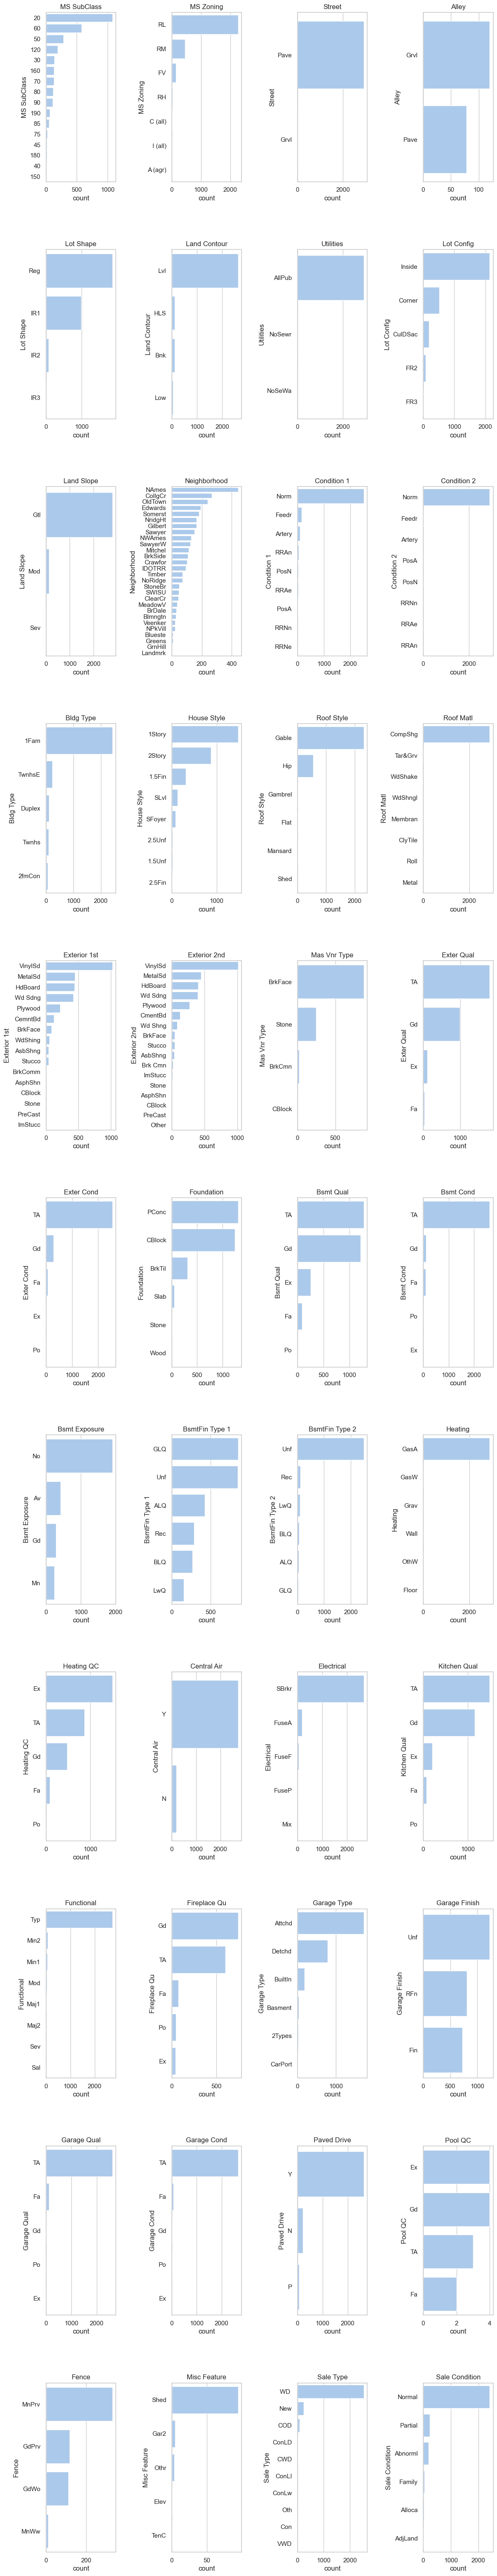

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


n_string_features = categorical_data.shape[1]

nrows, ncols = ceil(n_string_features / 4), 4

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 80))

axs = axs.ravel()

for feature_name, ax in zip_longest(categorical_data, axs):
    if feature_name is None:
        ax.axis("off")
        continue

    sns.countplot(
        y=categorical_data[feature_name],
        ax=ax,
        order=categorical_data[feature_name].value_counts().index
    )
    ax.set_title(feature_name)

plt.subplots_adjust(hspace=0.4, wspace=0.8)
plt.show()


### Correlação entre variáveis numéricas

#### Correlação entre _features_ e valor de venda

In [18]:
correlations = data.corr(numeric_only=True)
corr_with_sale_price = correlations[['SalePrice']]

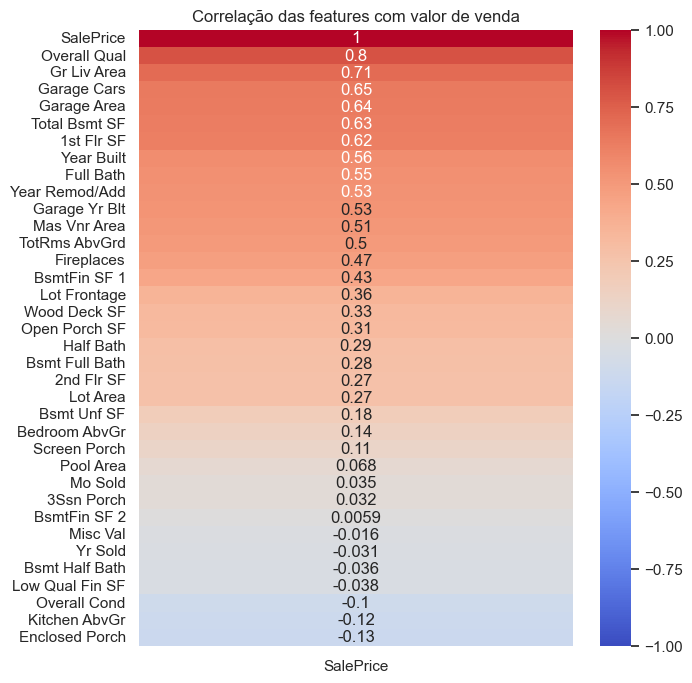

In [19]:
plt.figure(figsize=(7, 8))
sns.heatmap(corr_with_sale_price.sort_values(by='SalePrice', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlação das features com valor de venda")
plt.show()

Das variáveis com maior correlação com o preço de venda, a qualidade geral do imóvel (que indica a qualidade do material e acabamento usado e é representado por uma nota de 1 a 10) é a que apresenta a correlação mais alta com o valor de venda.

Em sequência, tem-se o tamanho da área de convivência, a capacidade e área da garagem e a área do sótão com as maiores correlações.

No caso das variáveis com correlação negativa, tem-se que casas com uma área de varanda cercada maior e com mais cozinhas tem uma tendência (leve) a ter um preço menor.

No caso de varandas cercadas, conforme análise abaixo, se vê uma correlação negativa (-0.4) com a idade do imóvel. Ou seja, quanto mais antiga a casa, maior a área de varanda cercada e vice-versa.

#### Correlação entre as _features_

In [20]:
features_corr = features.corr(numeric_only=True)
sorted_correlations = features_corr.unstack().sort_values(ascending=False)
sorted_correlations = sorted_correlations[sorted_correlations.index.get_level_values(0) < sorted_correlations.index.get_level_values(1)]
top_5_correlations = sorted_correlations.head(5)

print(top_5_correlations)
print('Maiores valores de correlação entre features:')

Garage Area    Garage Cars      0.889676
Garage Yr Blt  Year Built       0.834849
Gr Liv Area    TotRms AbvGrd    0.807772
1st Flr SF     Total Bsmt SF    0.800720
Bedroom AbvGr  TotRms AbvGrd    0.672647
dtype: float64
Maiores valores de correlação entre features:


In [21]:
bottom_5_correlations = sorted_correlations.tail(5)
print('Menores valores de correlação entre features:')
print(bottom_5_correlations)

Menores valores de correlação entre features:
Garage Yr Blt   Overall Cond   -0.326017
Overall Cond    Year Built     -0.368773
Enclosed Porch  Year Built     -0.374364
Bsmt Full Bath  Bsmt Unf SF    -0.399656
Bsmt Unf SF     BsmtFin SF 1   -0.477875
dtype: float64


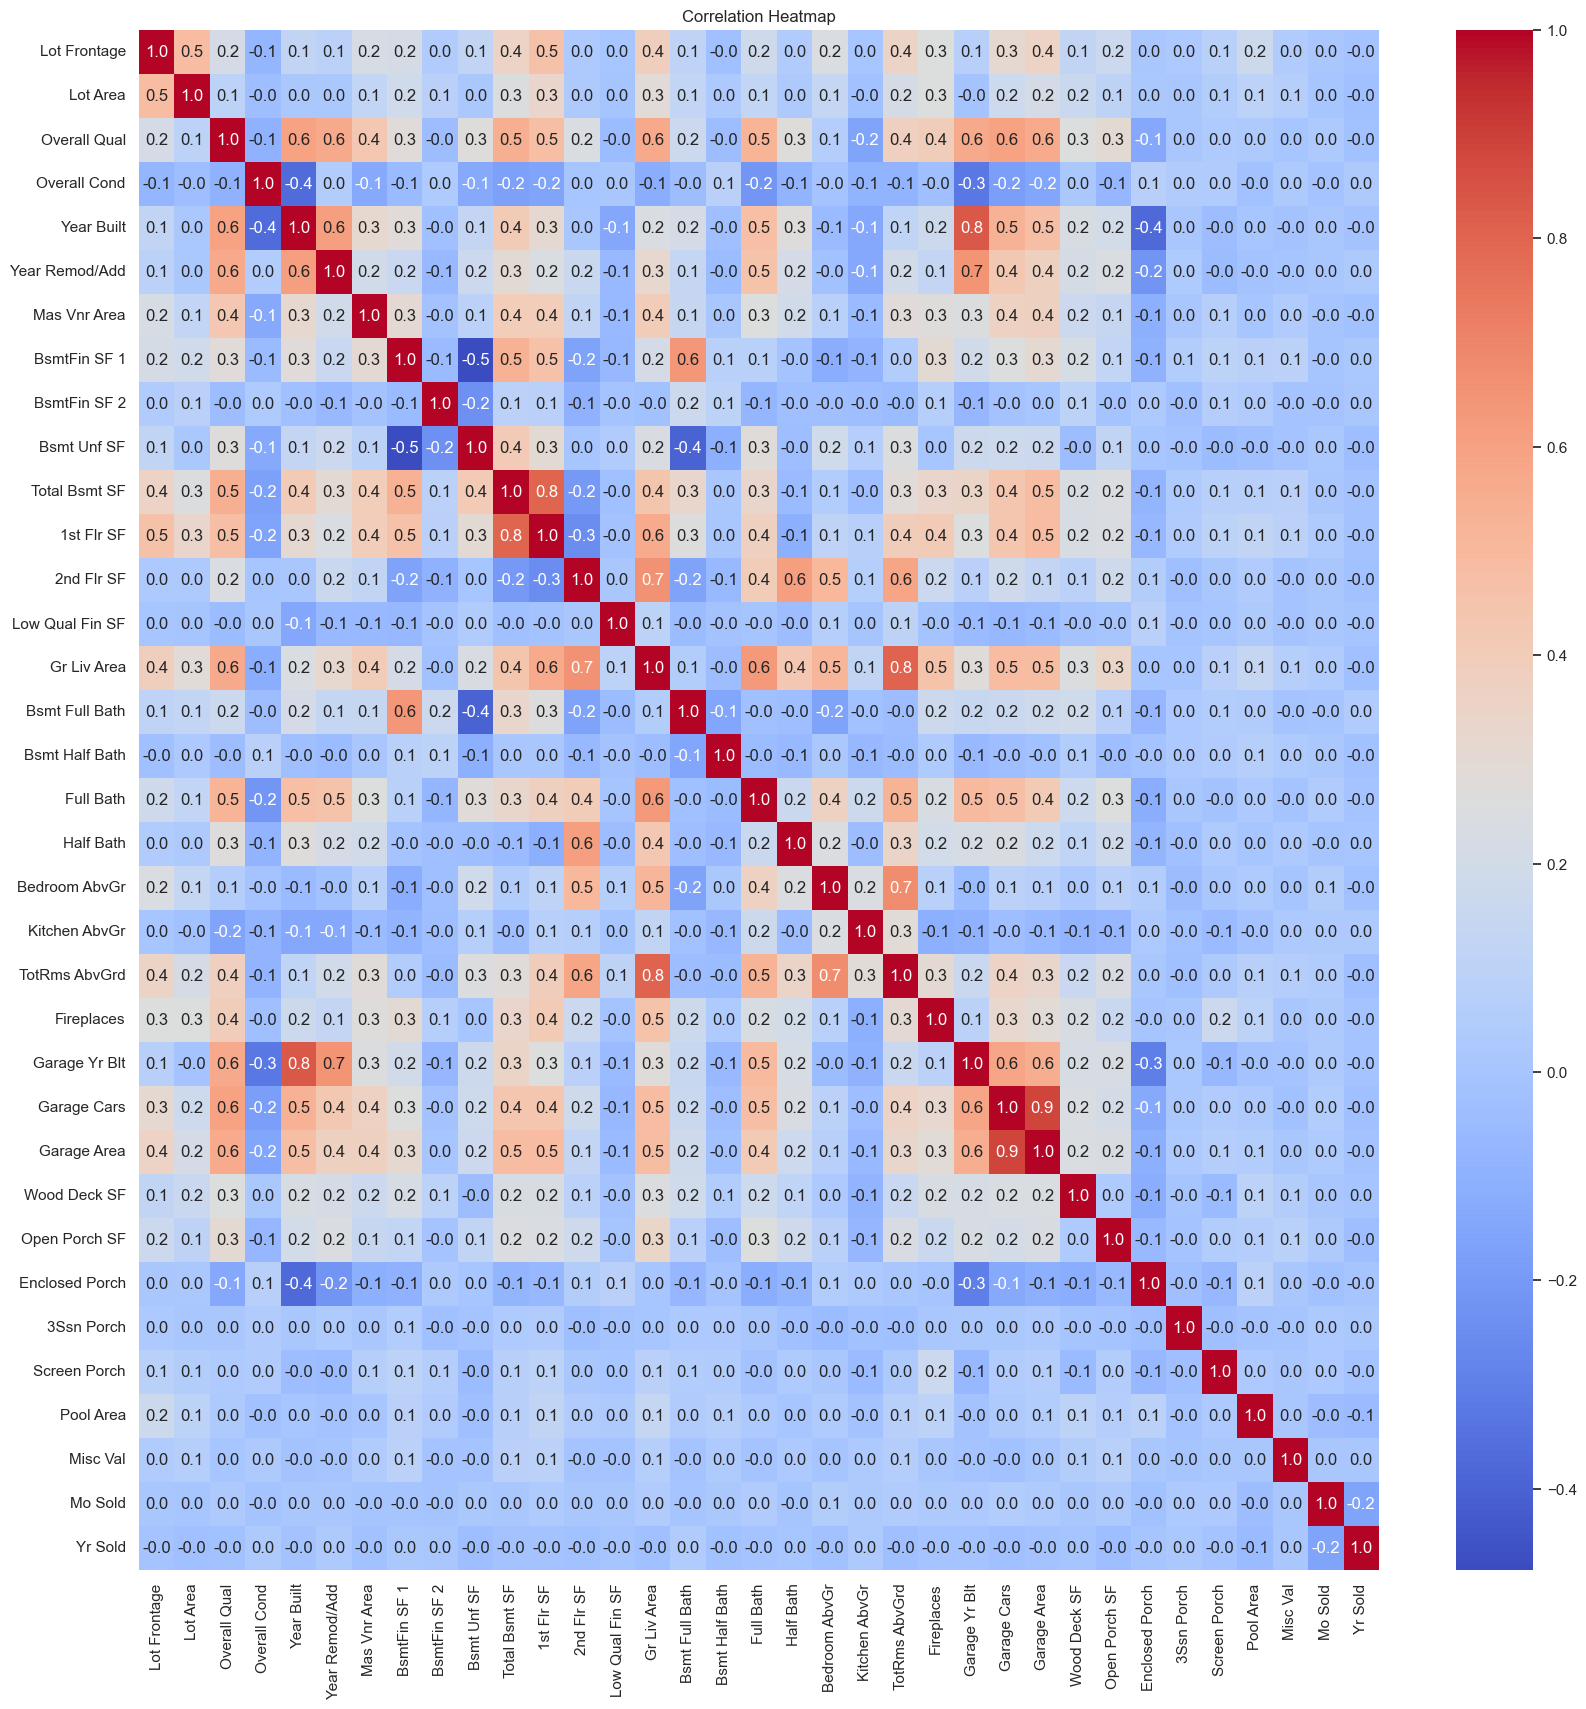

In [22]:
plt.figure(figsize=(20, 20))
sns.heatmap(features_corr, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Dado a análise acima, é possível notar algumas relações interessantes:
* A qualidade geral ("Overal qual") está fortemente correlacionada com o ano de construção e a capacidade da garagem;
* A área da piscina (que está igual a 0 para quase todos os imóveis) e o mês da venda tem correlação nula com praticamente todas as outras _features_;
* O tamanho da área de convivência tem correlação bastante alta (> 0.8) com o número de cômodos;
* A área do primeiro piso tem correlação bastante alta (0.8) com a área do porão;
* Forte correlação negativa entre “Bsmt Unf SF” (espaço do porão inacabado) e “BsmtFin SF 1” (espaço do porão acabado), indicando (de forma até óbvia) que à medida que a área do porão acabado aumenta, a área do porão inacabado diminui.

## ANOVA

Para determinar se variáveis (discretas ou categóricas) influenciam significativamente o preço de venda, é possível utilizar a análise de variância (ANOVA). Essa técnica compara as médias de dois ou mais grupos para identificar se as diferenças entre elas são estatisticamente significativas.

### Fatores

Na ANOVA, fatores são as variáveis independentes categóricas ou discretas que queremos testar para avaliar se elas afetam a variável dependente (neste caso, o preço de venda). Cada fator pode ter dois ou mais níveis ou valores (categorias).

No _dataset_ da cidade de Ames, por exemplo, podemos ter como fator o bairro (**Neighbourhood**) e os níveis sendo os bairros em si (Bloomington Heights, Bluestem, Briardale, etc.)

### Tipos de ANOVA

#### One-Way ANOVA (ANOVA de um fator):

Utilizada quando há apenas um fator (variável independente) com dois ou mais níveis.
Exemplo: Comparar o preço de venda entre diferentes tipos de bairros (residencial, comercial, industrial).

#### Two-Way ANOVA (ANOVA de dois fatores):

Utilizada para avaliar dois fatores simultaneamente e investigar interações entre eles.
Exemplo: Comparar o preço de venda considerando o tipo de bairro e a qualidade da construção.

#### Factorial ANOVA (ANOVA de n fatores):

Extensão do two-way ANOVA, inclunindo _n_ fatores cada um com 2 ou mais níveis.
Exemplo: Comparar o preço de venda considerando o tipo de bairro, a qualidade da construção e o tipo de garagem.

#### Repeated Measures ANOVA:

Usado para para comparar valores para três ou mais grupos relacionados, em que os mesmos indivíduos são medidos várias vezes sob diferentes condições ou pontos de tempo. Esse método é útil na análise de dados em que as observações não são independentes, pois vêm dos mesmos registros repetidamente.

### Pressupostos do ANOVA

* **Independência das observações**: A observação de determinada amostra não deve influenciar valores de outra amostra, ou seja, o valor de uma observação não deve prover informações sobre outra;

* **Homogeneidade de variâncias**: As variâncias de cada grupo devem ser aproximadamente a mesma. Isso quer dizer que a dispersão dos valores em torno da média de cada grupo deve ser semelhante entre os diferentes grupos.

    $\Large{H_0 = \sigma^{2}_{1} = \sigma^{2}_{2} = ... = \sigma^{2}_{n}}$

* **Normalidade dos dados**: Dados de cada grupo devem seguir uma distribuição normal.

### Fórmulas

Para utilizar o ANOVA, deve-se calcular uma estatística F que é dada pela razão entre a variância intergrupo e intragrupo. Essas suas medidas podem ser obtidas por meio do cálculo da razão entre o o quadrado médio entre os grupos (_QME_) e o quadrado médio dentro dos grupos (_QMD_):
    
$\Large{F = \frac{QME}{QMD}}$

onde:
* $\Large{QME = \frac{SQE}{k - 1} = \frac{\sum_{i=1}^k n_i (\bar{X}_i - \bar{X})^2}{k - 1}}$

* $\Large{QMD = \frac{SQD}{N - k} = \frac{\sum_{i=1}^k \sum_{j=1}^{n_{i}} ({X}_i - \bar{X})^2}{N - k}}$

  sendo: 
    * $X_{ij}$: Observação j no grupo i.
    * $\bar{X_{i}}$: Média do grupo i;
    * $\bar{X}$ : Média geral (média de todas as observações).
    * $n_j$: Número de observações no grupo i
    * N: Número total de observações
    * k: Número de grupos

### Variáveis escolhidas

No caso da análise do preço de vendas, o ANOVA será aplicado nas seguintes variáveis:
* número de vagas na garagem (**Garage Cars**);
* o ano de construção (**Year Built**);
* o bairro do imóvel (**Neighborhood**).

As duas primeiras serão usadas pelo valor alto de correlação com o preço de venda. O bairro será usado pois, em geral, a região do imóvel tem grande impacto no seu preço (incluindo quando dois imóveis possuem as mesmas características).

#### Seleção e agrupamento dos dados

In [23]:
anova_data = data[["Garage Cars", "Neighborhood", "Year Built", "SalePrice"]]
anova_data

Garage Cars Neighborhood  Year Built  SalePrice
0             2.0        NAmes        1960     215000
1             1.0        NAmes        1961     105000
2             1.0        NAmes        1958     172000
3             2.0        NAmes        1968     244000
4             2.0      Gilbert        1997     189900
...           ...          ...         ...        ...
2925          2.0      Mitchel        1984     142500
2926          2.0      Mitchel        1983     131000
2927          0.0      Mitchel        1992     132000
2928          2.0      Mitchel        1974     170000
2929          3.0      Mitchel        1993     188000

[2930 rows x 4 columns]

In [24]:
print('Números de vagas existentes:', anova_data['Garage Cars'].unique())

Números de vagas existentes: [ 2.  1.  3.  0.  4.  5. nan]


In [25]:
print('Anos de construção existentes:', anova_data['Year Built'].unique())

Anos de construção existentes: [1960 1961 1958 1968 1997 1998 2001 1992 1995 1999 1993 1990 1985 2003
 1988 2010 1951 1978 1977 1974 2000 1970 1971 1975 2009 2007 2005 2004
 2002 2006 1996 1994 2008 1980 1979 1984 1920 1965 1967 1963 1962 1976
 1972 1966 1959 1964 1950 1952 1949 1940 1954 1955 1957 1956 1953 1948
 1900 1910 1927 1915 1945 1929 1938 1923 1928 1890 1885 1922 1925 1939
 1942 1936 1930 1921 1912 1917 1907 1875 1969 1947 1946 1987 1941 1924
 1914 1931 1919 1989 1896 1973 1991 1981 1986 1916 1926 1935 1892 1898
 1880 1882 1937 1902 1934 1982 1983 1932 1918 1904 1905 1872 1893 1906
 1908 1911 1895 1879 1901 1913]


In [26]:
print('Bairros existentes:', anova_data['Neighborhood'].unique())

Bairros existentes: ['NAmes' 'Gilbert' 'StoneBr' 'NWAmes' 'Somerst' 'BrDale' 'NPkVill'
 'NridgHt' 'Blmngtn' 'NoRidge' 'SawyerW' 'Sawyer' 'Greens' 'BrkSide'
 'OldTown' 'IDOTRR' 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor'
 'Blueste' 'Mitchel' 'Timber' 'MeadowV' 'Veenker' 'GrnHill' 'Landmrk']


In [27]:
# Substituir valor faltante por 0
anova_data.loc[anova_data['Garage Cars'].isna(), 'Garage Cars'] = anova_data['Garage Cars'].fillna(0)

In [28]:
anova_data[anova_data['Garage Cars'].isna()]

Empty DataFrame
Columns: [Garage Cars, Neighborhood, Year Built, SalePrice]
Index: []

#### Visualização das distribuições por nível de cada grupo

##### Número de vagas

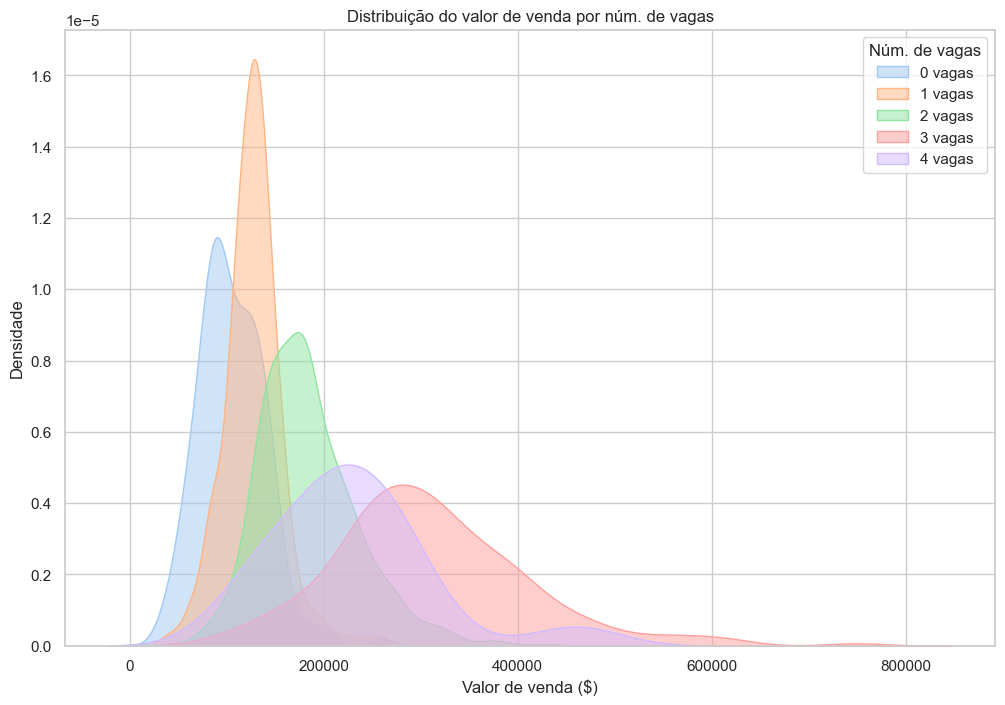

In [29]:
plt.figure(figsize=(12, 8))

for num in sorted(anova_data['Garage Cars'].dropna().unique()):
    sns.kdeplot(
        data=anova_data[anova_data['Garage Cars'] == num]['SalePrice'],
        label=f'{int(num)} vagas',
        fill=True,
        warn_singular=False,
        alpha=0.5
    )

plt.title('Distribuição do valor de venda por núm. de vagas')
plt.xlabel('Valor de venda ($)')
plt.ylabel('Densidade')
plt.legend(title='Núm. de vagas')
plt.show()

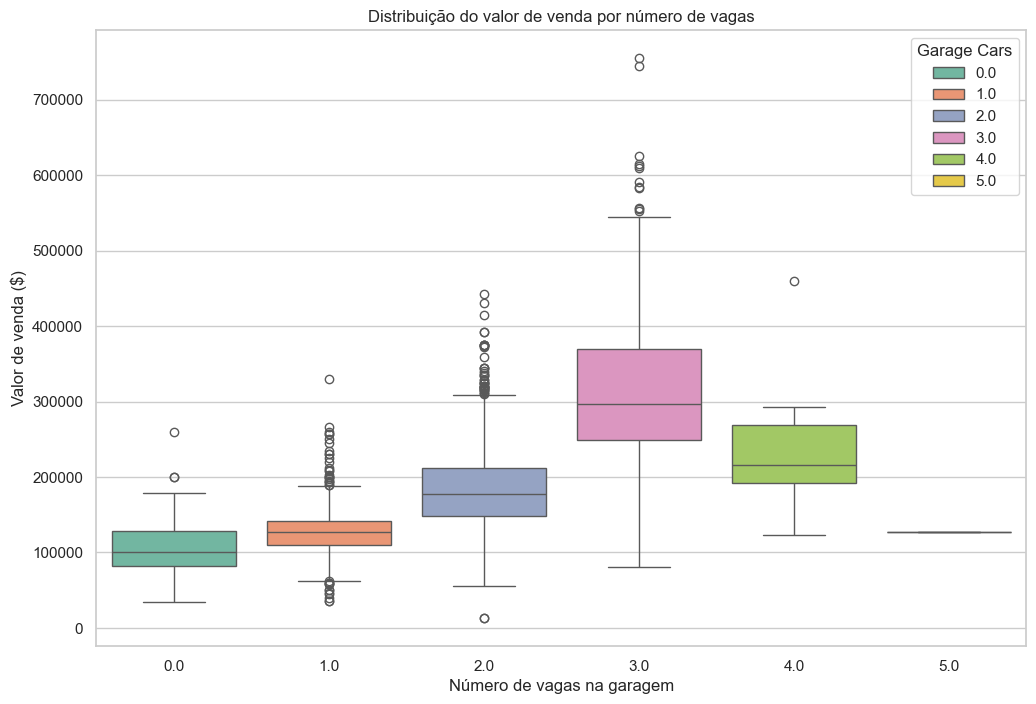

In [30]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=anova_data,
    x='Garage Cars',
    y='SalePrice',
    palette='Set2',
    hue='Garage Cars',
)

# Add title and labels
plt.title('Distribuição do valor de venda por número de vagas')
plt.xlabel('Número de vagas na garagem')
plt.ylabel('Valor de venda ($)')

plt.show()

##### Ano de construção

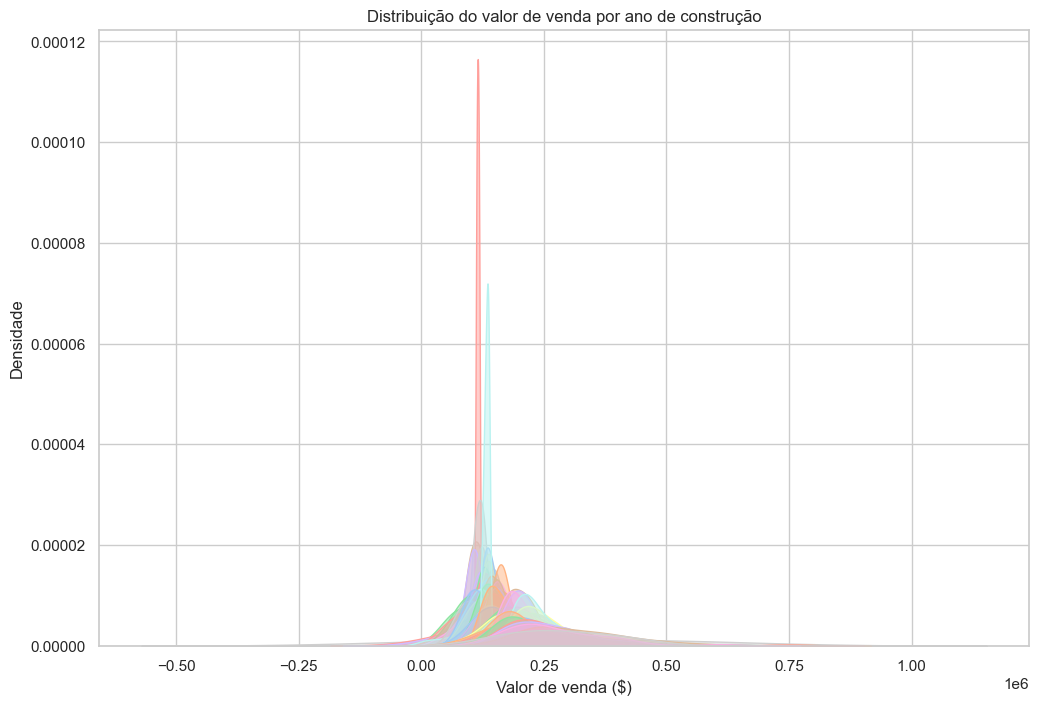

In [31]:
plt.figure(figsize=(12, 8))

for num in sorted(anova_data['Year Built'].dropna().unique()):
    sns.kdeplot(
        data=anova_data[anova_data['Year Built'] == num]['SalePrice'],
        label=f'{int(num)}',
        fill=True,
        warn_singular=False,
        alpha=0.5
    )

plt.title('Distribuição do valor de venda por ano de construção')
plt.xlabel('Valor de venda ($)')
plt.ylabel('Densidade')
plt.show()

/tmp/ipykernel_16041/50697369.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1960' '1961' '1958' ... '1992' '1974' '1993']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_plot_data.loc[:,'Year Built'] = box_plot_data['Year Built'].astype(int).astype(str)


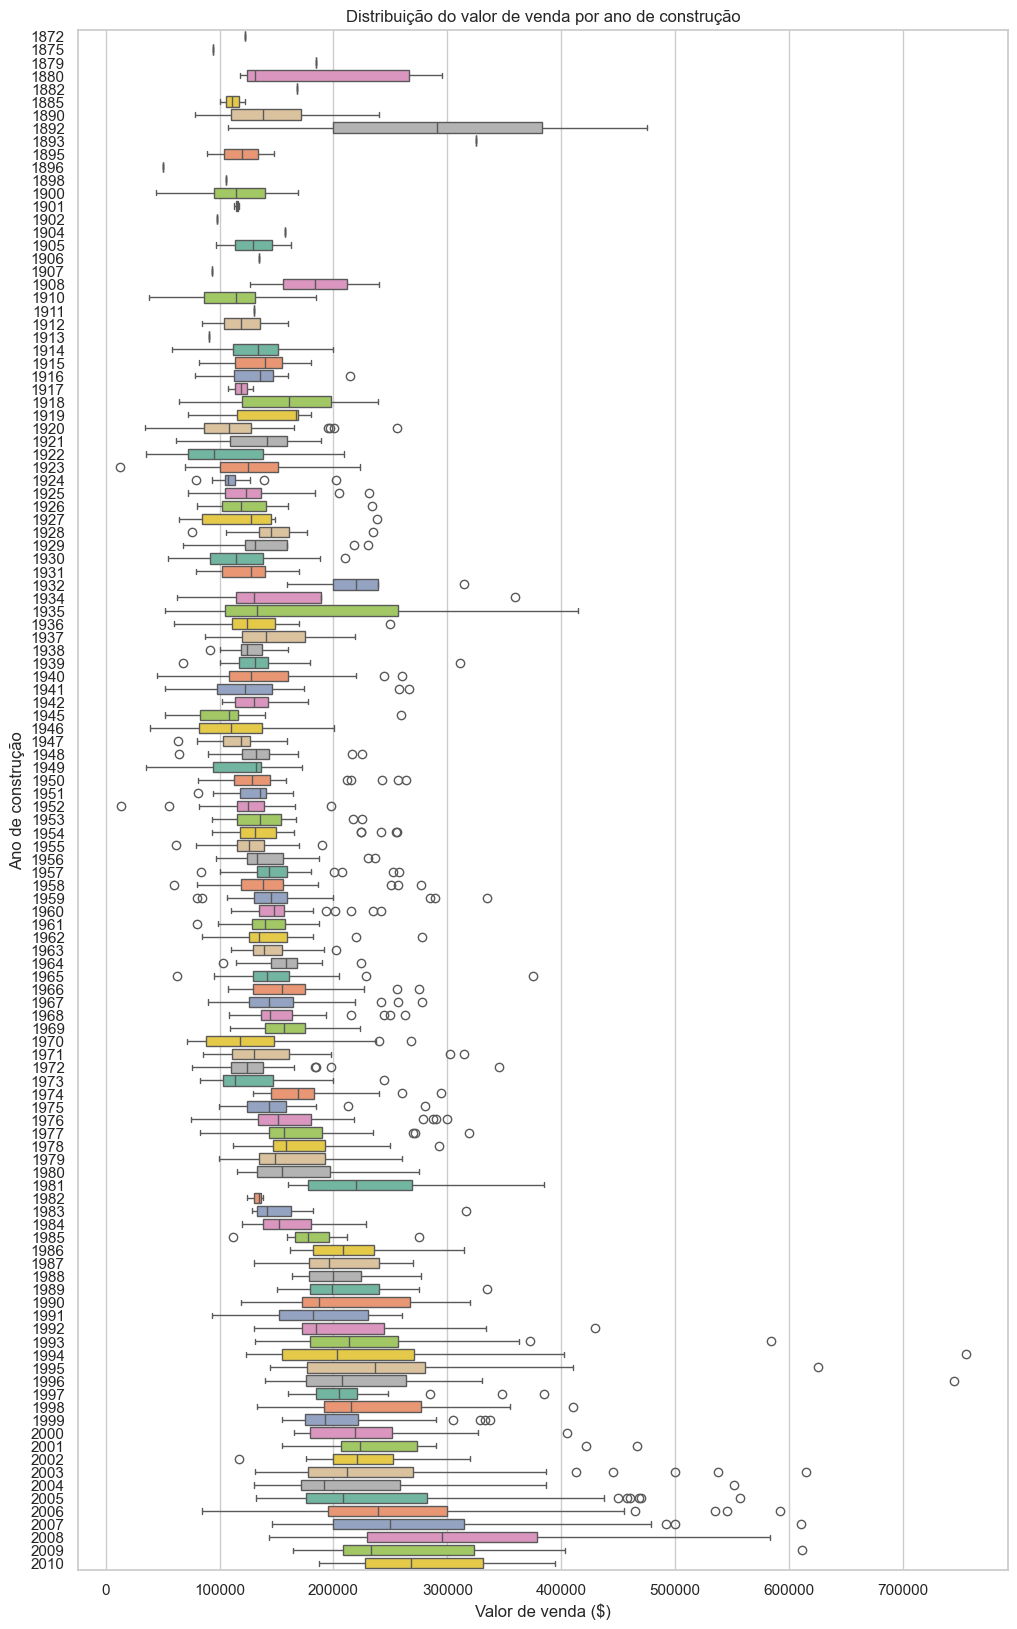

In [32]:
plt.figure(figsize=(12, 20))

box_plot_data = anova_data.copy()
box_plot_data.loc[:,'Year Built'] = box_plot_data['Year Built'].astype(int).astype(str)

sns.boxplot(
    data=box_plot_data.sort_values(by='Year Built'),
    x='SalePrice',
    y='Year Built',
    palette='Set2',
    hue='Year Built',
)

plt.title('Distribuição do valor de venda por ano de construção')
plt.ylabel('Ano de construção')
plt.xlabel('Valor de venda ($)')


plt.show()

##### Bairro

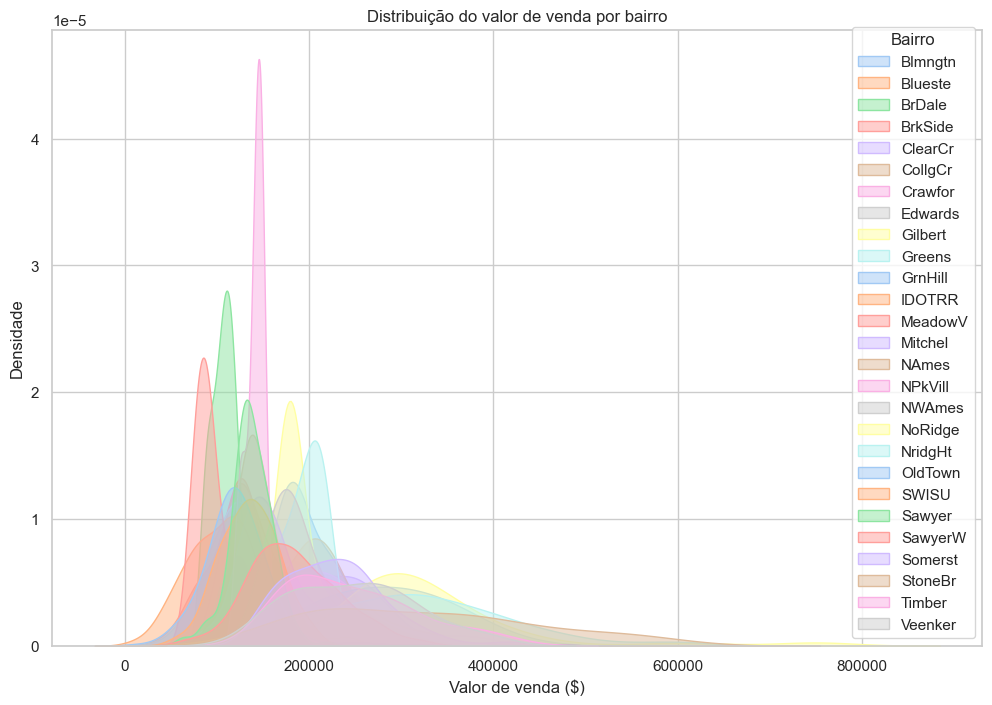

In [33]:
plt.figure(figsize=(12, 8))


for b in sorted(anova_data['Neighborhood'].dropna().unique()):
    sns.kdeplot(
        data=anova_data[anova_data['Neighborhood'] == b]['SalePrice'],
        label=f'{b}',
        fill=True,
        warn_singular=False,
        alpha=0.5
    )

plt.title('Distribuição do valor de venda por bairro')
plt.xlabel('Valor de venda ($)')
plt.ylabel('Densidade')
plt.legend(title='Bairro')
plt.show()

/tmp/ipykernel_16041/3709031947.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1960' '1961' '1958' ... '1992' '1974' '1993']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_plot_data.loc[:,'Year Built'] = box_plot_data['Year Built'].astype(int).astype(str)


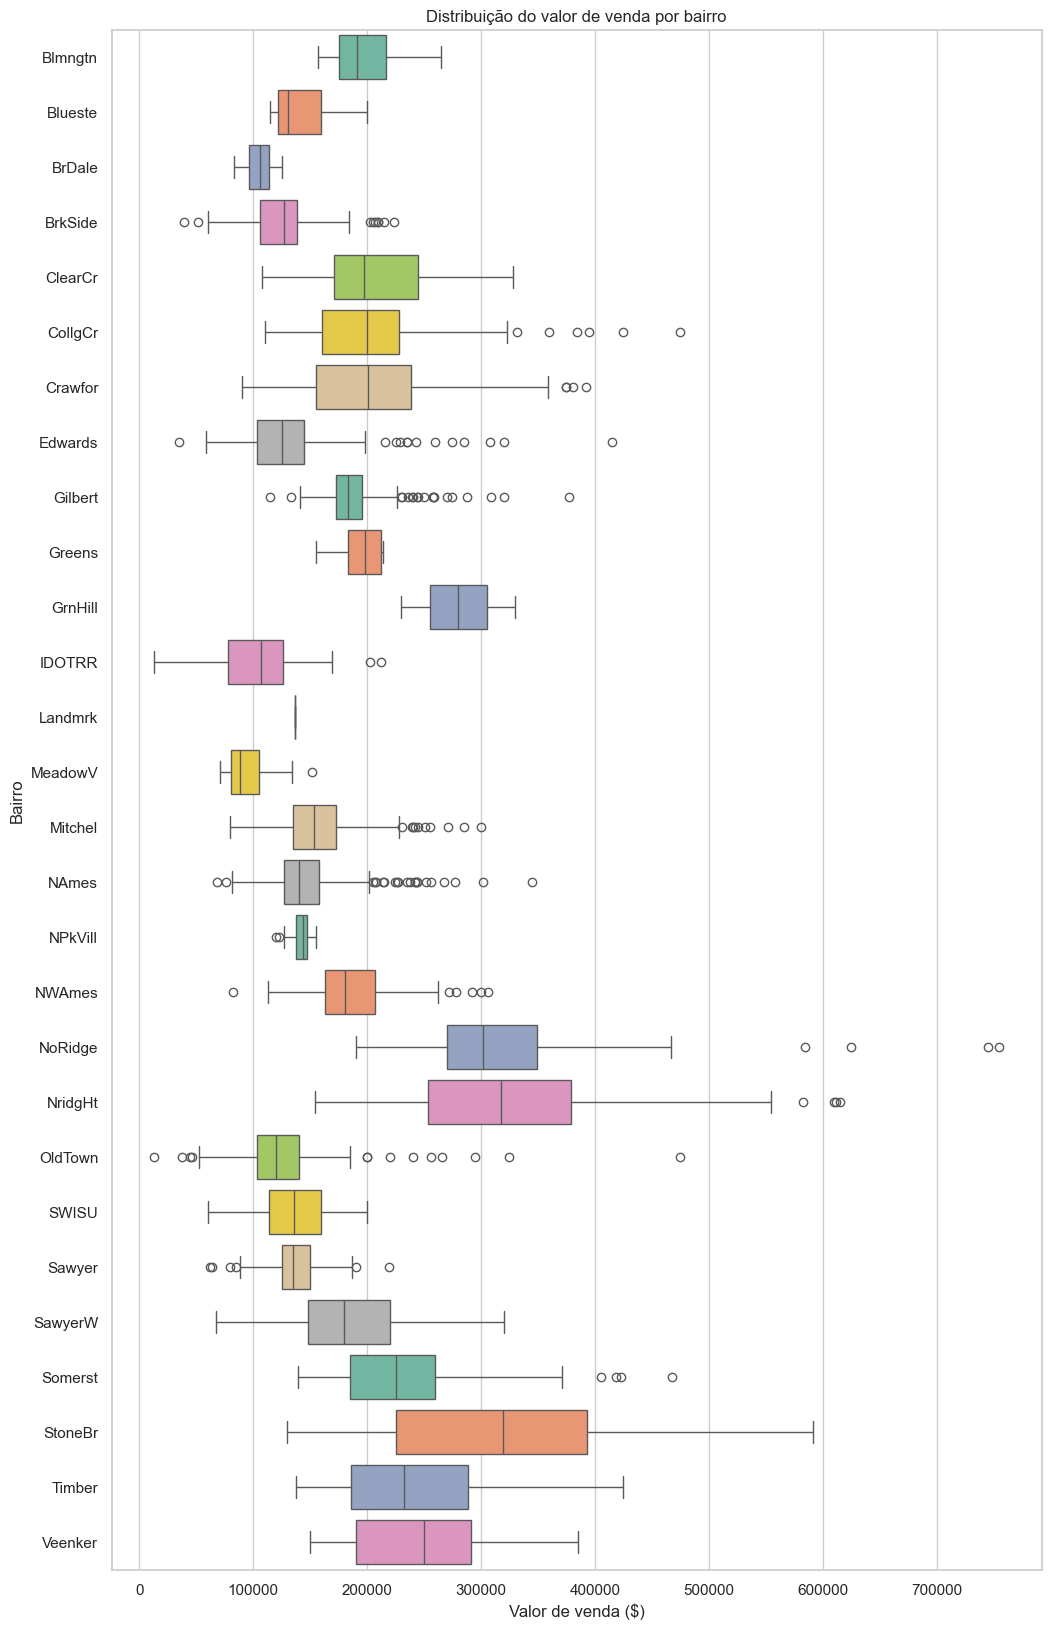

In [34]:
plt.figure(figsize=(12, 20))

box_plot_data = anova_data.copy()
box_plot_data.loc[:,'Year Built'] = box_plot_data['Year Built'].astype(int).astype(str)
sns.boxplot(
    data=box_plot_data.sort_values(by='Neighborhood'),
    x='SalePrice',
    y='Neighborhood',
    palette='Set2',
    hue='Neighborhood',
)

plt.title('Distribuição do valor de venda por bairro')
plt.ylabel('Bairro')
plt.xlabel('Valor de venda ($)')


plt.show()

#### Checagem dos pressupostos

##### Verificação da Normalidade

Para verificar que os dados de cada grupo seguem uma distribuição normal, dois testes serão usados:

* Gŕafico Q-Q: ferramenta visual usada para comparar a distribuição dos dados com a distribuição normal. Se os pontos no gráfico Q-Q seguirem uma linha reta (diagonal), isso sugere que os dados seguem uma distribuição normal.
* Teste de Shapiro-Wilk: teste estatístico utilizado para avaliar a normalidade dos dados. A hipótese nula do teste é que os dados seguem uma distribuição normal. Se o p-valor do teste for superior a um determinado nível de significância (geralmente 0.05), não se pode rejeitar a hipótese nula, ou seja, os dados podem ser considerados normalmente distribuídos. 

###### Q-Q Plot - Número de vagas

/home/joaorobson/Documentos/mestrado/analise/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/joaorobson/Documentos/mestrado/analise/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/joaorobson/Documentos/mestrado/analise/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


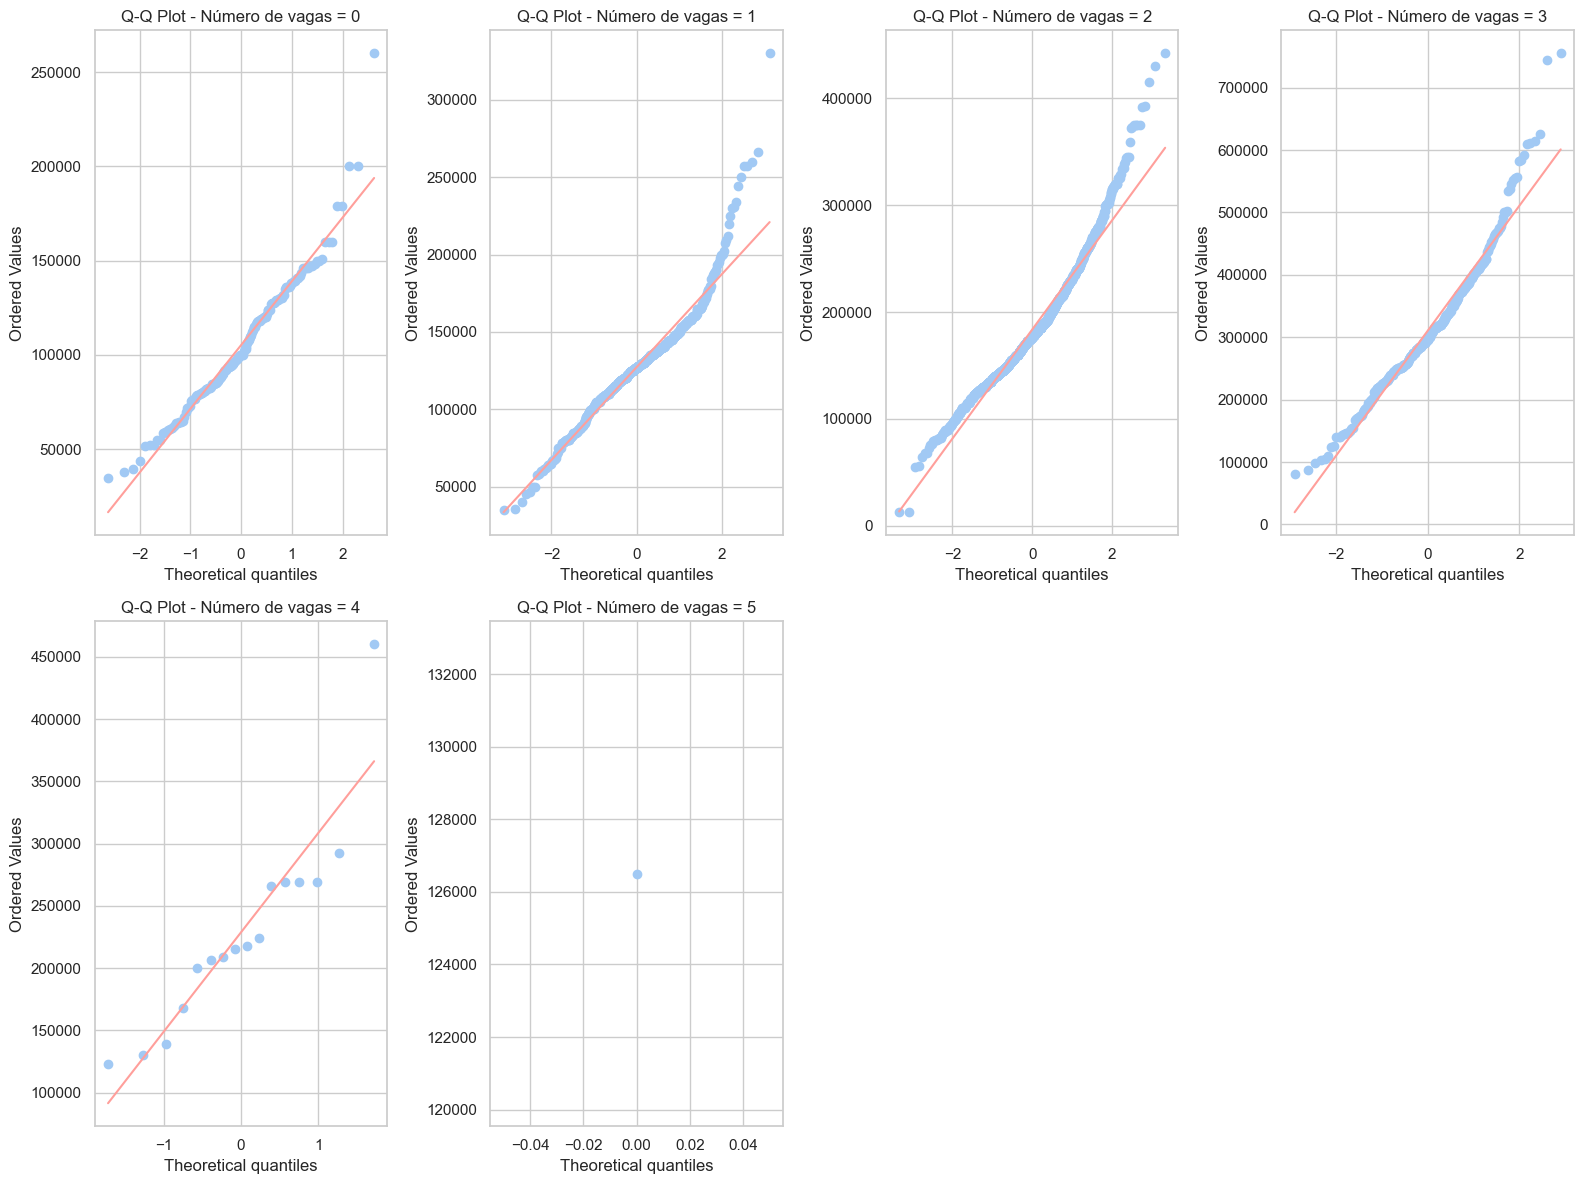

In [35]:
sns.set_theme(style="whitegrid", palette='Set2')

# Unique garage car counts
num_garage_cars = anova_data['Garage Cars'].dropna().unique()
num_garage_cars.sort()

# Define the number of columns and rows for the subplots
ncols = 4
nrows = (len(num_garage_cars) + ncols - 1) // ncols

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6 * nrows))
axes = axes.flatten()

# Generate Q-Q plots for each group
for i, num in enumerate(num_garage_cars):
    group = anova_data[anova_data['Garage Cars'] == num]['SalePrice'].dropna()
    
    ax = axes[i]
    stats.probplot(group, dist="norm", plot=ax)
    
    ax.set_title(f"Q-Q Plot - Número de vagas = {int(num)}")
    ax.grid(True)  # Ensure grid lines for consistency with Seaborn theme

# Turn off unused axes
for j in range(len(num_garage_cars), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

###### Teste de Shapiro-Wilk - Número de vagas

In [36]:
for i, num in enumerate(num_garage_cars):
    group = anova_data[anova_data['Garage Cars'] == num]['SalePrice']
    if len(group) >= 3:
        stat, p_value = stats.shapiro(group)
        print(f"Teste de normalidade para o grupo com número de vagas = {int(num)}: p-valor = {p_value}")
        
        if p_value > 0.05:
            print(f'O grupo com número de vagas = {int(num)} é normalmente distribuído\n\n')
        else:
            print(f'O grupo com número de vagas = {int(num)} não é normalmente distribuído\n\n')

Teste de normalidade para o grupo com número de vagas = 0: p-valor = 0.00034696148654941004
O grupo com número de vagas = 0 não é normalmente distribuído


Teste de normalidade para o grupo com número de vagas = 1: p-valor = 1.9470318103072302e-17
O grupo com número de vagas = 1 não é normalmente distribuído


Teste de normalidade para o grupo com número de vagas = 2: p-valor = 1.286892160237674e-20
O grupo com número de vagas = 2 não é normalmente distribuído


Teste de normalidade para o grupo com número de vagas = 3: p-valor = 8.073764006444037e-09
O grupo com número de vagas = 3 não é normalmente distribuído


Teste de normalidade para o grupo com número de vagas = 4: p-valor = 0.03041080136929493
O grupo com número de vagas = 4 não é normalmente distribuído




###### Q-Q Plot - Ano de construção

In [37]:
num_years = anova_data['Year Built'].unique()
num_years.sort()
num_years

array([1872, 1875, 1879, 1880, 1882, 1885, 1890, 1892, 1893, 1895, 1896,
       1898, 1900, 1901, 1902, 1904, 1905, 1906, 1907, 1908, 1910, 1911,
       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
       1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1934,
       1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

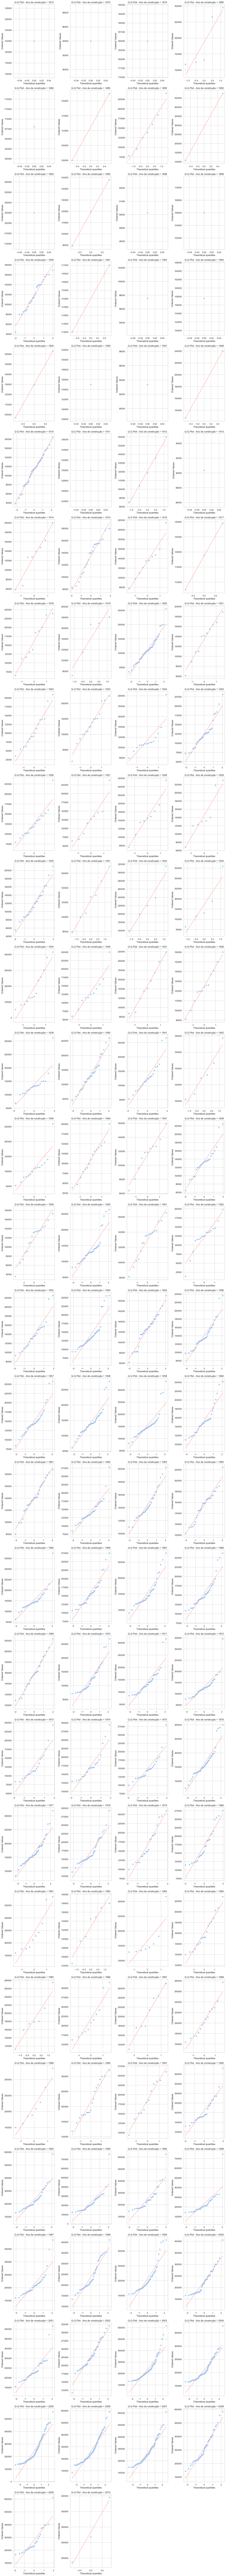

In [38]:
ncols = 4 
nrows = (len(num_years) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6 * nrows))
axes = axes.flatten()

for i, num in enumerate(num_years):
    group = anova_data[anova_data['Year Built'] == num]['SalePrice']
    
    ax = axes[i]
    stats.probplot(group, dist="norm", plot=ax)
    
    ax.set_title(f"Q-Q Plot - Ano de construção = {num}")

for j in range(len(num_years), len(axes)):
    axes[j].axis('off')  # Turn off unused axes

plt.tight_layout()
plt.show()

###### Teste de Shapiro-Wilk - Ano de construção

In [39]:
for i, year in enumerate(num_years):
    
    group = anova_data[anova_data['Year Built'] == year]['SalePrice']
    if len(group) >= 3:
        stat, p_value = stats.shapiro(group)
        message = 'Não é normalmente distribuído' if p_value < 0.05 else 'É normalmente distribuído'
        print(f'Teste para {year}: p-value: {p_value} ===> {message}')

Teste para 1880: p-value: 0.05174518831993148 ===> É normalmente distribuído
Teste para 1890: p-value: 0.8853055849632341 ===> É normalmente distribuído
Teste para 1895: p-value: 0.9588902970127895 ===> É normalmente distribuído
Teste para 1900: p-value: 0.500543209443652 ===> É normalmente distribuído
Teste para 1905: p-value: 0.981650737529981 ===> É normalmente distribuído
Teste para 1910: p-value: 0.9648752044622204 ===> É normalmente distribuído
Teste para 1912: p-value: 0.9902272074150945 ===> É normalmente distribuído
Teste para 1914: p-value: 0.5586978661006639 ===> É normalmente distribuído
Teste para 1915: p-value: 0.27673315035952606 ===> É normalmente distribuído
Teste para 1916: p-value: 0.693442115838624 ===> É normalmente distribuído
Teste para 1917: p-value: 0.9498906927274425 ===> É normalmente distribuído
Teste para 1918: p-value: 0.6281212187424267 ===> É normalmente distribuído
Teste para 1919: p-value: 0.2187003716373826 ===> É normalmente distribuído
Teste para 19

###### Q-Q Plot - Bairro

In [40]:
anova_data['Neighborhood'].value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

In [41]:
neighborhoods = anova_data['Neighborhood'].unique()
neighborhoods.sort()

/home/joaorobson/Documentos/mestrado/analise/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/joaorobson/Documentos/mestrado/analise/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/joaorobson/Documentos/mestrado/analise/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


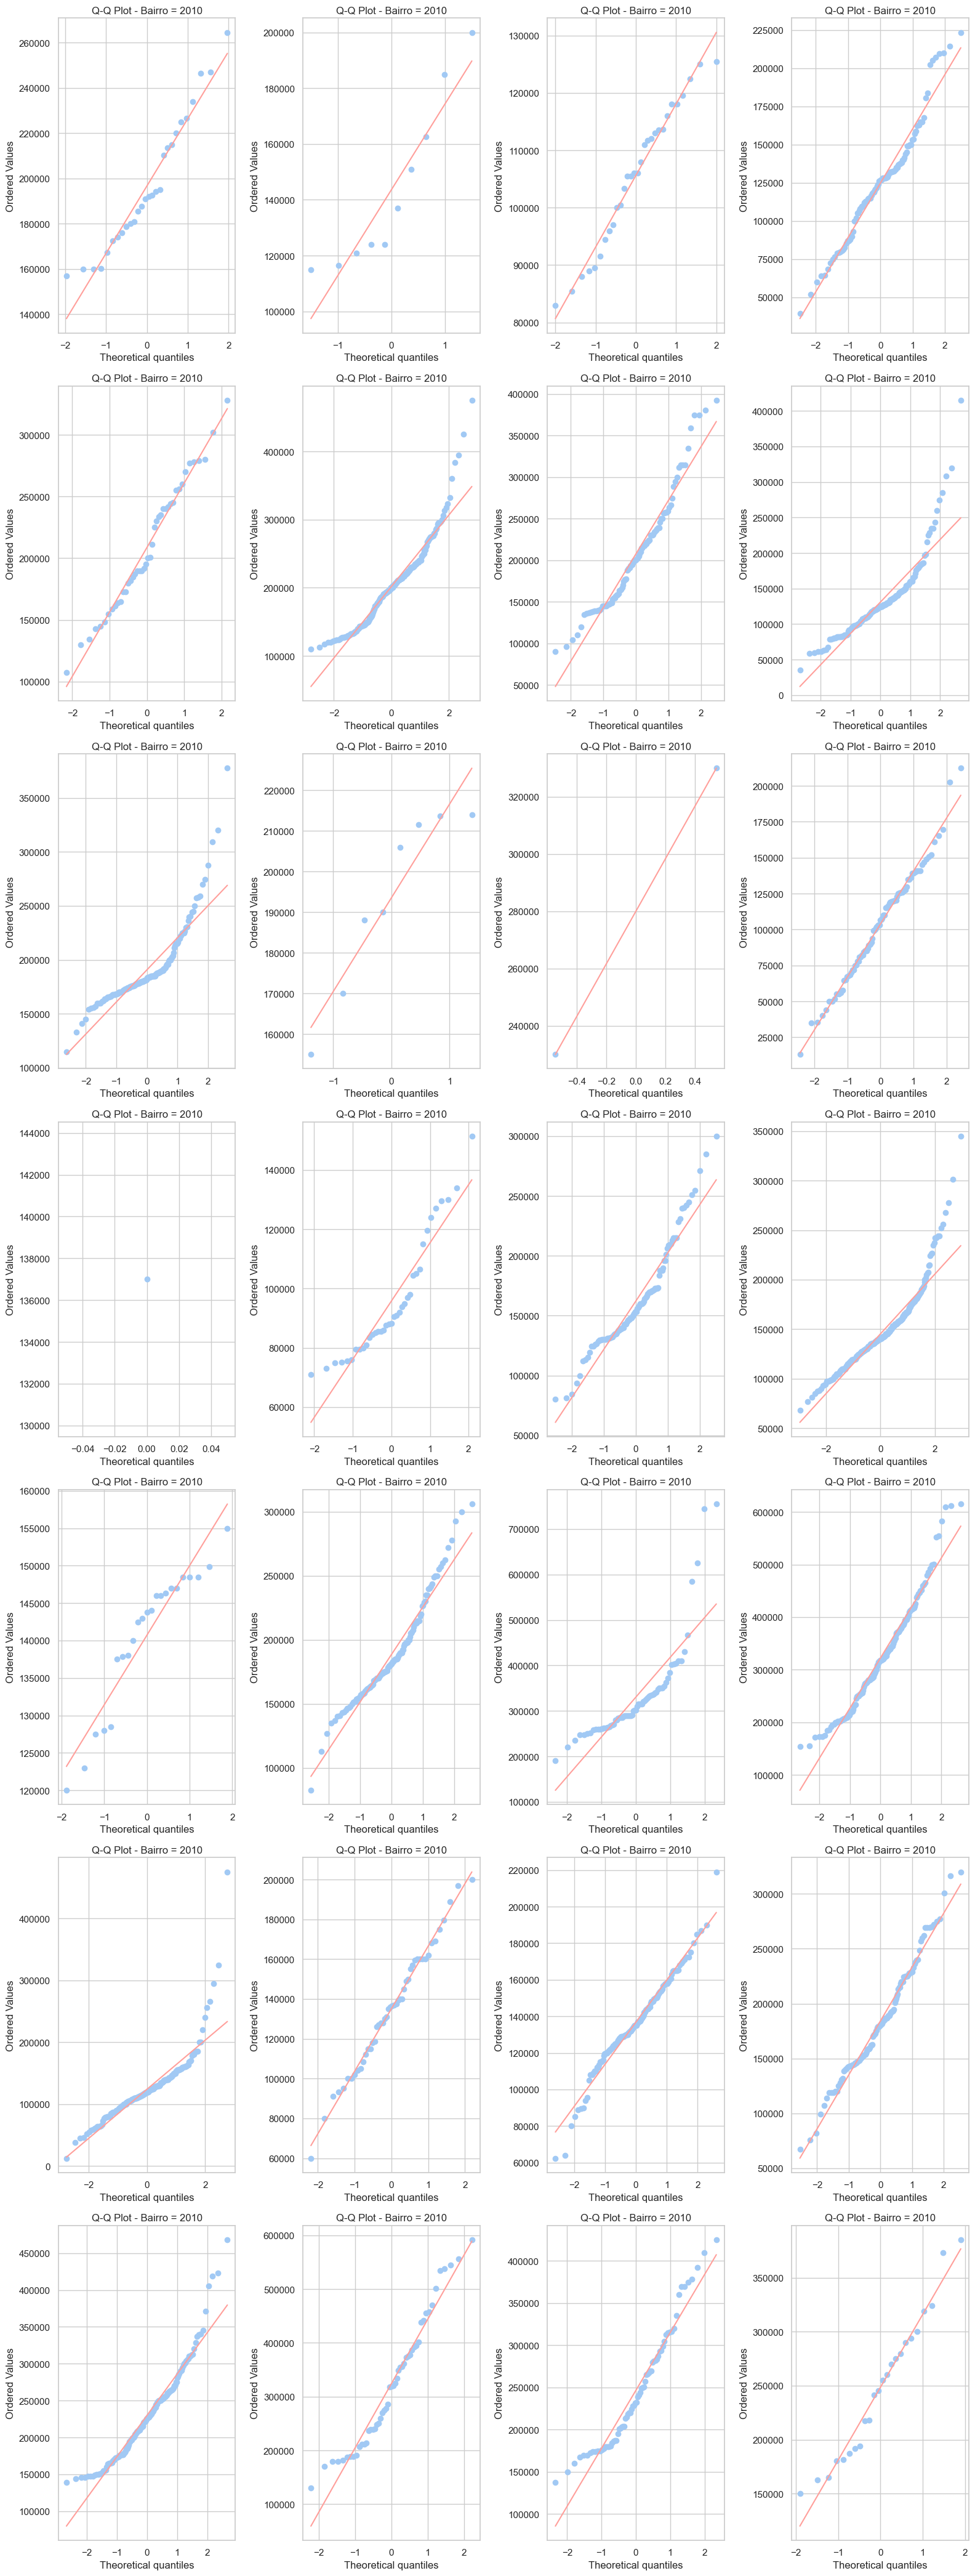

In [42]:
ncols = 4 
nrows = (len(neighborhoods) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6 * nrows))
axes = axes.flatten()

for i, n in enumerate(neighborhoods):
    group = anova_data[anova_data['Neighborhood'] == n]['SalePrice']
    
    ax = axes[i]
    stats.probplot(group, dist="norm", plot=ax)
    
    ax.set_title(f"Q-Q Plot - Bairro = {num}")

for j in range(len(neighborhoods), len(axes)):
    axes[j].axis('off')  # Turn off unused axes

plt.tight_layout()
plt.show()

###### Teste de Shapiro-Wilk - Bairro

In [43]:
for i, n in enumerate(neighborhoods):
    
    group = anova_data[anova_data['Neighborhood'] == n]['SalePrice']
    if len(group) >= 3:
        stat, p_value = stats.shapiro(group)
        message = 'Não é normalmente distribuído' if p_value < 0.05 else 'É normalmente distribuído'
        print(f'Teste para {n}: p-value: {p_value} ===> {message}')

Teste para Blmngtn: p-value: 0.11663211634290238 ===> É normalmente distribuído
Teste para Blueste: p-value: 0.08252896441393633 ===> É normalmente distribuído
Teste para BrDale: p-value: 0.38928243641038257 ===> É normalmente distribuído
Teste para BrkSide: p-value: 0.006494447524226965 ===> Não é normalmente distribuído
Teste para ClearCr: p-value: 0.5537581517455117 ===> É normalmente distribuído
Teste para CollgCr: p-value: 4.162976796933535e-10 ===> Não é normalmente distribuído
Teste para Crawfor: p-value: 0.0003848630455699623 ===> Não é normalmente distribuído
Teste para Edwards: p-value: 1.7031499072047162e-13 ===> Não é normalmente distribuído
Teste para Gilbert: p-value: 1.0349366202152243e-13 ===> Não é normalmente distribuído
Teste para Greens: p-value: 0.1826224861521602 ===> É normalmente distribuído
Teste para IDOTRR: p-value: 0.6134871224485963 ===> É normalmente distribuído
Teste para MeadowV: p-value: 0.0012603169015310627 ===> Não é normalmente distribuído
Teste par

##### Verificação de homocedasticidade

A homocedasticidade é um pressuposto importante na ANOVA que afirma que as variâncias de cada grupo devem ser aproximadamente iguais. Ou seja, a variabilidade dos dados dentro de cada grupo não pode ser significativamente diferente de um grupo para outro. Esse pressuposto é crucial porque a ANOVA assume que a dispersão das observações em torno da média é consistente em todos os grupos, o que afeta a precisão dos testes e a validade dos resultados.

Quando esse pressuposto é violado, ou seja, quando há heterocedasticidade (variâncias desiguais), os resultados da ANOVA podem ser distorcidos, levando a conclusões erradas sobre a significância estatística.

Para verificar se os grupos seguem esse pressuposto, podemos aplicar o teste de Levene, que se baseia nas seguintes hipóteses:

* H0 (hipótese nula): As variâncias dos grupos são iguais (homocedasticidade).
* H1 (hipótese alternativa): Pelo menos uma variância é diferente (heterocedasticidade).

###### Teste de Levene - Número de vagas

In [44]:
stat, p_value = stats.levene(*[anova_data[anova_data['Garage Cars'] == group]['SalePrice'] for group in num_garage_cars])

print(f"Teste de homocedasticidade (Levene): p-valor = {p_value}")

if p_value > 0.05:
    print("As variâncias são homogêneas (homocedasticidade confirmada)")
else:
    print("As variâncias não são homogêneas (homocedasticidade violada)")

Teste de homocedasticidade (Levene): p-valor = 3.3836735407082798e-102
As variâncias não são homogêneas (homocedasticidade violada)


###### Teste de Levene - Ano de construção

In [45]:
stat, p_value = stats.levene(*[anova_data[anova_data['Year Built'] == group]['SalePrice'] for group in num_years])

print(f"Teste de homocedasticidade (Levene): p-valor = {p_value}")

if p_value > 0.05:
    print("As variâncias são homogêneas (homocedasticidade confirmada)")
else:
    print("As variâncias não são homogêneas (homocedasticidade violada)")

Teste de homocedasticidade (Levene): p-valor = 5.840898592962907e-45
As variâncias não são homogêneas (homocedasticidade violada)


###### Teste de Levene - Bairro

In [46]:
stat, p_value = stats.levene(*[anova_data[anova_data['Neighborhood'] == group]['SalePrice'] for group in neighborhoods])

print(f"Teste de homocedasticidade (Levene): p-valor = {p_value}")

if p_value > 0.05:
    print("As variâncias são homogêneas (homocedasticidade confirmada)")
else:
    print("As variâncias não são homogêneas (homocedasticidade violada)")

Teste de homocedasticidade (Levene): p-valor = 2.915202579905449e-112
As variâncias não são homogêneas (homocedasticidade violada)


##### Verificação da Independência dos Erros

A independência dos erros é um pressuposto importante na análise de variância (ANOVA). Ele significa que os erros (resíduos) de uma observação não devem influenciar os erros de outra observação. Em outras palavras, os erros de uma amostra não podem ser correlacionados entre si. Se esse pressuposto for violado, os resultados da ANOVA podem não ser válidos, o que pode afetar a confiança nas conclusões da análise.

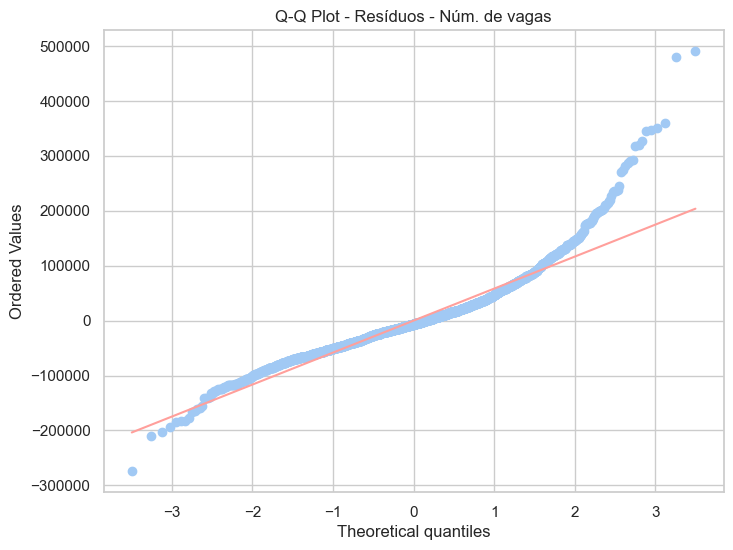

In [47]:
model = smf.ols("SalePrice ~ Q('Garage Cars')", data=anova_data).fit()
residuals = model.resid

sns.set_theme(style="whitegrid", palette="Set2")

fig, ax = plt.subplots(figsize=(8, 6))

stats.probplot(residuals, dist="norm", plot=ax)
plt.title('Q-Q Plot - Resíduos - Núm. de vagas')
plt.show()

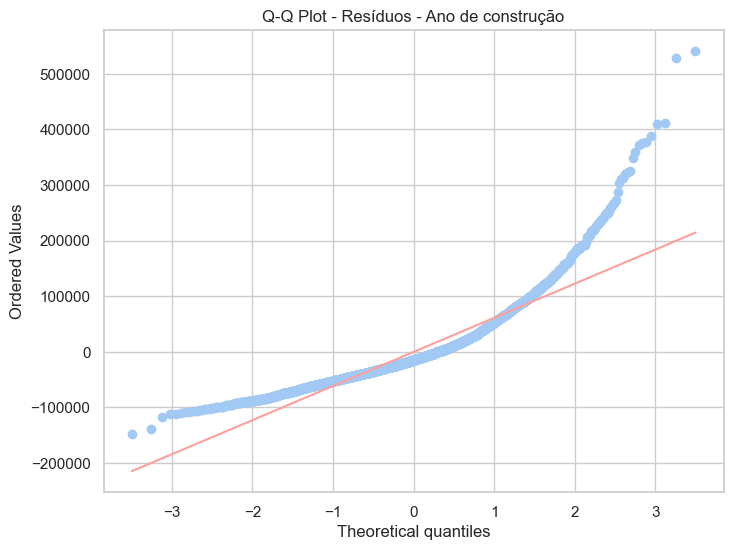

In [48]:
model = smf.ols("SalePrice ~ Q('Year Built')", data=anova_data).fit()
residuals = model.resid

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot - Resíduos - Ano de construção')
plt.show()

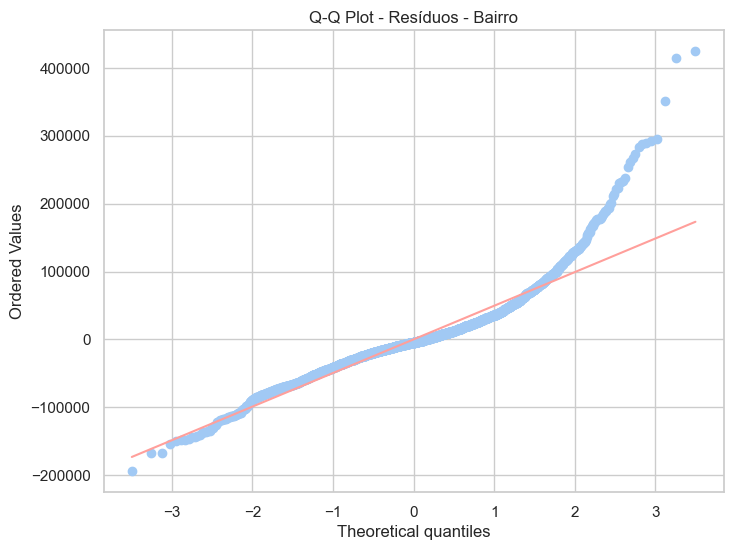

In [49]:
model = smf.ols("SalePrice ~ Q('Neighborhood')", data=anova_data).fit()
residuals = model.resid

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot - Resíduos - Bairro')
plt.show()

Como mostrado nas análises acima, muitos níveis nos grupos não seguem os pressupostos (normalizade e homoscedasticidade, principalmente). Dessa forma, um teste não-paramétrico (Kruskal-Wallis) será abordado abaixo.

Esse teste permite comparar três ou mais grupos independentes que não seguem uma distribuição normal. Nesse sentido, ele se baseia nas seguintes hipóteses:

* H0: as medianas de todos os grupos são iguais;
* H1: pelo menos uma mediana é diferente. 

## Teste não-paramétrico (Kruskal-Wallis) 

### Número de vagas

In [50]:
from scipy.stats import kruskal

  
stat, p = kruskal(*[anova_data[anova_data['Garage Cars'] == num]['SalePrice'] for num in num_garage_cars])
print('Estatítistica= %.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Os grupos têm a mesma distribuição de preços de venda. (Não rejeita H0)')
else:
    print('Pelo menos um dos grupos possui uma distribuição diferente de preços de venda (rejeita H0)')


Estatítistica= 1459.143, p=0.000
Pelo menos um dos grupos possui uma distribuição diferente de preços de venda (rejeita H0)


### Ano de construção

In [51]:
from scipy.stats import kruskal

  
stat, p = kruskal(*[anova_data[anova_data['Year Built'] == num]['SalePrice'] for num in num_years])
print('Estatítistica= %.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Os grupos têm a mesma distribuição de preços de venda. (Não rejeita H0)')
else:
    print('Pelo menos um dos grupos possui uma distribuição diferente de preços de venda (rejeita H0)')


Estatítistica= 1623.970, p=0.000
Pelo menos um dos grupos possui uma distribuição diferente de preços de venda (rejeita H0)


### Bairro

In [52]:
from scipy.stats import kruskal

stat, p = kruskal(*[anova_data[anova_data['Neighborhood'] == num]['SalePrice'] for num in neighborhoods])
print('Estatítistica= %.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Os grupos têm a mesma distribuição de preços de venda. (Não rejeita H0)')
else:
    print('Pelo menos um dos grupos possui uma distribuição diferente de preços de venda (rejeita H0)')


Estatítistica= 1798.767, p=0.000
Pelo menos um dos grupos possui uma distribuição diferente de preços de venda (rejeita H0)


## Teste pós-hoc

Para determinar quais grupos específicos diferem entre si, podemos utilizar um teste pós-hoc.

O teste de Dunn geralmente é utilizado quando os resultados do teste de Kruskal-Wallis são estatisticamente relevantes. Ele funciona retornando um p-valor (no caso abaixo, ajustado conforme o método de Bonferroni, que múltiplica o valor original de p pelo número de comparações feitas).

Nesse contexto, as hipóteses são:

* H₀: As distribuições das duas populações são iguais.
* H₁: As distribuições das duas populações são diferentes.

Se tivermos um valor de p para determinada comparação entre um grupo i e um grupo j menor que um nível de significância (aqui, 0.05), tem-se a rejeição da hipótese nula, ou seja, um indicativo de que os grupos são significativamente diferentes.

### Número de vagas

In [53]:
dunn_results = sp.posthoc_dunn(anova_data, val_col='SalePrice', group_col='Garage Cars', p_adjust='bonferroni')
dunn_results

0.0            1.0            2.0            3.0           4.0  \
0.0   1.000000e+00   7.739695e-04   6.369549e-64  3.363260e-146  8.746749e-12   
1.0   7.739695e-04   1.000000e+00  1.197350e-130  5.345619e-243  1.746484e-08   
2.0   6.369549e-64  1.197350e-130   1.000000e+00   4.481351e-71  9.263433e-01   
3.0  3.363260e-146  5.345619e-243   4.481351e-71   1.000000e+00  4.116657e-01   
4.0   8.746749e-12   1.746484e-08   9.263433e-01   4.116657e-01  1.000000e+00   
5.0   1.000000e+00   1.000000e+00   1.000000e+00   3.968276e-01  1.000000e+00   

          5.0  
0.0  1.000000  
1.0  1.000000  
2.0  1.000000  
3.0  0.396828  
4.0  1.000000  
5.0  1.000000

In [54]:
print('Distribuições significativamente diferentes (Núm. de vagas):')
mask = (dunn_results < 0.05) & (dunn_results != 1)
for i in range(len(dunn_results)):
    for j in range(i):
        if mask.iloc[i, j]:
            print(f'{dunn_results.index[i]} vs {dunn_results.index[j]}, p-valor: {dunn_results.iloc[i, j]:.6f}')

Distribuições significativamente diferentes (Núm. de vagas):
1.0 vs 0.0, p-valor: 0.000774
2.0 vs 0.0, p-valor: 0.000000
2.0 vs 1.0, p-valor: 0.000000
3.0 vs 0.0, p-valor: 0.000000
3.0 vs 1.0, p-valor: 0.000000
3.0 vs 2.0, p-valor: 0.000000
4.0 vs 0.0, p-valor: 0.000000
4.0 vs 1.0, p-valor: 0.000000


### Ano de construção

In [55]:
dunn_results = sp.posthoc_dunn(anova_data, val_col='SalePrice', group_col='Year Built', p_adjust='bonferroni')
dunn_results

1872  1875  1879  1880  1882  1885      1890  1892  1893      1895  ...  \
1872   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
1875   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
1879   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
1880   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
1882   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
...    ...   ...   ...   ...   ...   ...       ...   ...   ...       ...  ...   
2006   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
2007   1.0   1.0   1.0   1.0   1.0   1.0  0.817712   1.0   1.0  1.000000  ...   
2008   1.0   1.0   1.0   1.0   1.0   1.0  0.098999   1.0   1.0  0.831283  ...   
2009   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
2010   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   

      2001  2002  2003     2004  2005  2006  2007  2008  2009  2010  
1872   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
1875   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
1879   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
1880   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
1882   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
...    ...   ...   ...      ...   ...   ...   ...   ...   ...   ...  
2006   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
2007   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
2008   1.0   1.0   1.0  0.71786   1.0   1.0   1.0   1.0   1.0   1.0  
2009   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
2010   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  

[118 rows x 118 columns]

In [56]:
dunn_results

1872  1875  1879  1880  1882  1885      1890  1892  1893      1895  ...  \
1872   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
1875   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
1879   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
1880   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
1882   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
...    ...   ...   ...   ...   ...   ...       ...   ...   ...       ...  ...   
2006   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
2007   1.0   1.0   1.0   1.0   1.0   1.0  0.817712   1.0   1.0  1.000000  ...   
2008   1.0   1.0   1.0   1.0   1.0   1.0  0.098999   1.0   1.0  0.831283  ...   
2009   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   
2010   1.0   1.0   1.0   1.0   1.0   1.0  1.000000   1.0   1.0  1.000000  ...   

      2001  2002  2003     2004  2005  2006  2007  2008  2009  2010  
1872   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
1875   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
1879   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
1880   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
1882   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
...    ...   ...   ...      ...   ...   ...   ...   ...   ...   ...  
2006   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
2007   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
2008   1.0   1.0   1.0  0.71786   1.0   1.0   1.0   1.0   1.0   1.0  
2009   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  
2010   1.0   1.0   1.0  1.00000   1.0   1.0   1.0   1.0   1.0   1.0  

[118 rows x 118 columns]

In [57]:
print('Distribuições significativamente diferentes (Ano de construção):')
mask = (dunn_results < 0.05) & (dunn_results != 1)
years_diff = np.array([])

for i in range(len(dunn_results)):
    for j in range(i):
        if mask.iloc[i, j]:
            print(f'{dunn_results.index[i]} vs {dunn_results.index[j]}, p-valor: {dunn_results.iloc[i, j]:.6f}')
            years_diff = np.append(years_diff, abs(int(dunn_results.index[i] - dunn_results.index[j])))

Distribuições significativamente diferentes (Ano de construção):
1974 vs 1910, p-valor: 0.019001
1974 vs 1920, p-valor: 0.007027
1976 vs 1910, p-valor: 0.032564
1976 vs 1920, p-valor: 0.006390
1977 vs 1910, p-valor: 0.000698
1977 vs 1920, p-valor: 0.000073
1978 vs 1910, p-valor: 0.000349
1978 vs 1920, p-valor: 0.000047
1980 vs 1920, p-valor: 0.029074
1981 vs 1900, p-valor: 0.003415
1981 vs 1910, p-valor: 0.000176
1981 vs 1920, p-valor: 0.000086
1981 vs 1922, p-valor: 0.010933
1981 vs 1924, p-valor: 0.003072
1981 vs 1925, p-valor: 0.008248
1981 vs 1930, p-valor: 0.005370
1981 vs 1945, p-valor: 0.003869
1981 vs 1946, p-valor: 0.020988
1981 vs 1949, p-valor: 0.033455
1981 vs 1955, p-valor: 0.010189
1981 vs 1970, p-valor: 0.006222
1981 vs 1972, p-valor: 0.010161
1981 vs 1973, p-valor: 0.046474
1986 vs 1900, p-valor: 0.005416
1986 vs 1910, p-valor: 0.000253
1986 vs 1920, p-valor: 0.000118
1986 vs 1922, p-valor: 0.018135
1986 vs 1924, p-valor: 0.005031
1986 vs 1925, p-valor: 0.013183
1986 vs

In [58]:
print('Núm. de pares com diferença significativa de distribuição:', len(years_diff))

Núm. de pares com diferença significativa de distribuição: 896


In [59]:
print('Média dos pares com diferença significativa de distribuição:', years_diff.mean())

Média dos pares com diferença significativa de distribuição: 53.447544642857146


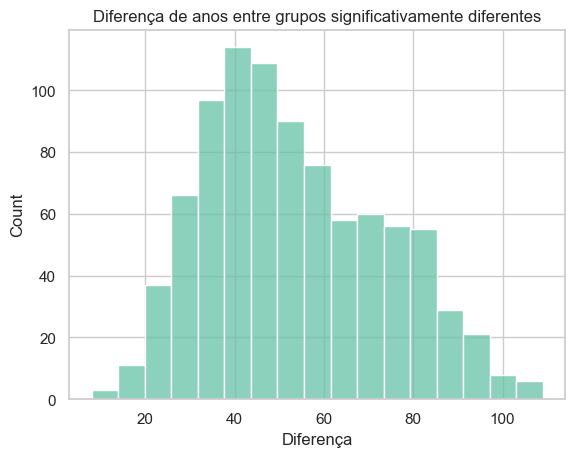

In [60]:
sns.histplot(years_diff)
plt.title('Diferença de anos entre grupos significativamente diferentes')
plt.xlabel('Diferença')
plt.show()

### Bairro

In [61]:
dunn_results = sp.posthoc_dunn(anova_data, val_col='SalePrice', group_col='Neighborhood', p_adjust='bonferroni')
dunn_results

Blmngtn   Blueste        BrDale       BrkSide       ClearCr  \
Blmngtn  1.000000e+00  1.000000  9.336659e-11  3.584307e-09  1.000000e+00   
Blueste  1.000000e+00  1.000000  1.000000e+00  1.000000e+00  4.592373e-01   
BrDale   9.336659e-11  1.000000  1.000000e+00  1.000000e+00  5.686121e-14   
BrkSide  3.584307e-09  1.000000  1.000000e+00  1.000000e+00  5.768801e-14   
ClearCr  1.000000e+00  0.459237  5.686121e-14  5.768801e-14  1.000000e+00   
CollgCr  1.000000e+00  0.561886  3.652175e-19  1.693476e-30  1.000000e+00   
Crawfor  1.000000e+00  0.716620  1.792739e-16  8.660557e-21  1.000000e+00   
Edwards  3.523134e-09  1.000000  1.000000e+00  1.000000e+00  1.201600e-14   
Gilbert  1.000000e+00  0.842526  2.036742e-17  1.093177e-24  1.000000e+00   
Greens   1.000000e+00  1.000000  6.181474e-04  3.635389e-02  1.000000e+00   
GrnHill  1.000000e+00  1.000000  1.141549e-01  9.322844e-01  1.000000e+00   
IDOTRR   9.122499e-14  1.000000  1.000000e+00  1.000000e+00  3.148248e-20   
Landmrk  1.000000e+00  1.000000  1.000000e+00  1.000000e+00  1.000000e+00   
MeadowV  6.391656e-13  1.000000  1.000000e+00  1.000000e+00  4.064964e-17   
Mitchel  2.955694e-01  1.000000  1.204245e-06  1.559545e-05  1.162310e-02   
NAmes    2.748567e-05  1.000000  1.349748e-03  8.516410e-02  3.093443e-09   
NPkVill  3.329496e-02  1.000000  1.000000e+00  1.000000e+00  3.907797e-03   
NWAmes   1.000000e+00  1.000000  2.502562e-15  7.404183e-20  1.000000e+00   
NoRidge  3.665219e-02  0.000002  4.292036e-35  2.797663e-49  4.672022e-03   
NridgHt  5.923427e-02  0.000003  1.756833e-39  2.329096e-69  4.684886e-03   
OldTown  2.646441e-11  1.000000  1.000000e+00  1.000000e+00  4.943052e-18   
SWISU    9.456363e-05  1.000000  1.000000e+00  1.000000e+00  6.357612e-07   
Sawyer   1.703827e-06  1.000000  1.265646e-01  1.000000e+00  1.886243e-10   
SawyerW  1.000000e+00  1.000000  1.364970e-12  5.387953e-15  1.000000e+00   
Somerst  1.000000e+00  0.008614  2.698999e-26  7.168848e-43  1.000000e+00   
StoneBr  1.000000e+00  0.000106  5.615278e-27  4.030548e-33  6.754837e-01   
Timber   1.000000e+00  0.004499  1.379273e-23  1.987813e-30  1.000000e+00   
Veenker  1.000000e+00  0.022065  5.861435e-15  7.501357e-14  1.000000e+00   

              CollgCr       Crawfor       Edwards       Gilbert    Greens  \
Blmngtn  1.000000e+00  1.000000e+00  3.523134e-09  1.000000e+00  1.000000   
Blueste  5.618859e-01  7.166199e-01  1.000000e+00  8.425260e-01  1.000000   
BrDale   3.652175e-19  1.792739e-16  1.000000e+00  2.036742e-17  0.000618   
BrkSide  1.693476e-30  8.660557e-21  1.000000e+00  1.093177e-24  0.036354   
ClearCr  1.000000e+00  1.000000e+00  1.201600e-14  1.000000e+00  1.000000   
CollgCr  1.000000e+00  1.000000e+00  1.421044e-40  1.000000e+00  1.000000   
Crawfor  1.000000e+00  1.000000e+00  3.794845e-24  1.000000e+00  1.000000   
Edwards  1.421044e-40  3.794845e-24  1.000000e+00  1.214067e-30  0.060412   
Gilbert  1.000000e+00  1.000000e+00  1.214067e-30  1.000000e+00  1.000000   
Greens   1.000000e+00  1.000000e+00  6.041197e-02  1.000000e+00  1.000000   
GrnHill  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000   
IDOTRR   4.155253e-42  8.813349e-30  7.620792e-01  5.373154e-35  0.000755   
Landmrk  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000   
MeadowV  3.503223e-25  4.588529e-21  2.234917e-01  1.162040e-22  0.000147   
Mitchel  6.884492e-06  1.128940e-03  5.282711e-06  2.889674e-04  1.000000   
NAmes    2.060533e-33  1.755291e-16  5.051462e-02  1.790958e-22  1.000000   
NPkVill  9.123623e-04  3.004760e-03  1.000000e+00  2.820307e-03  1.000000   
NWAmes   1.000000e+00  1.000000e+00  1.052528e-23  1.000000e+00  1.000000   
NoRidge  4.554860e-10  3.644010e-07  1.713848e-56  2.293923e-09  1.000000   
NridgHt  2.739583e-15  5.891196e-09  2.233348e-89  4.991593e-13  1.000000   
OldTown  2.001527e-54  5.993985e-31  1.000000e+00  2.670839e-40  0.014529   
SWISU    9.352812e-11  1.577133e-08  1.000000e+00  3.204717e-09  0.576990   
Sawyer   

In [62]:
print('Distribuições significativamente diferentes (Bairro):')
mask = (dunn_results < 0.05) & (dunn_results != 1)
num_neighborhoods_diff = 0
for i in range(len(dunn_results)):
    for j in range(i):
        if mask.iloc[i, j]:
            num_neighborhoods_diff += 1
            print(f'{dunn_results.index[i]} vs {dunn_results.index[j]}, p-valor: {dunn_results.iloc[i, j]:.6f}')

Distribuições significativamente diferentes (Bairro):
BrDale vs Blmngtn, p-valor: 0.000000
BrkSide vs Blmngtn, p-valor: 0.000000
ClearCr vs BrDale, p-valor: 0.000000
ClearCr vs BrkSide, p-valor: 0.000000
CollgCr vs BrDale, p-valor: 0.000000
CollgCr vs BrkSide, p-valor: 0.000000
Crawfor vs BrDale, p-valor: 0.000000
Crawfor vs BrkSide, p-valor: 0.000000
Edwards vs Blmngtn, p-valor: 0.000000
Edwards vs ClearCr, p-valor: 0.000000
Edwards vs CollgCr, p-valor: 0.000000
Edwards vs Crawfor, p-valor: 0.000000
Gilbert vs BrDale, p-valor: 0.000000
Gilbert vs BrkSide, p-valor: 0.000000
Gilbert vs Edwards, p-valor: 0.000000
Greens vs BrDale, p-valor: 0.000618
Greens vs BrkSide, p-valor: 0.036354
IDOTRR vs Blmngtn, p-valor: 0.000000
IDOTRR vs ClearCr, p-valor: 0.000000
IDOTRR vs CollgCr, p-valor: 0.000000
IDOTRR vs Crawfor, p-valor: 0.000000
IDOTRR vs Gilbert, p-valor: 0.000000
IDOTRR vs Greens, p-valor: 0.000755
MeadowV vs Blmngtn, p-valor: 0.000000
MeadowV vs ClearCr, p-valor: 0.000000
MeadowV vs 

In [63]:
print('Número de pares distintos de bairros:', 28*27/2)
print('Número de pares com diferença de distribuição de preços significativa:', num_neighborhoods_diff)
print(f'% pares com diferença de distribuição de preços significativa: {100*num_neighborhoods_diff/(28*27/2):.2f}%')

Número de pares distintos de bairros: 378.0
Número de pares com diferença de distribuição de preços significativa: 187
% pares com diferença de distribuição de preços significativa: 49.47%


## Conclusões

### Análise exploratória

* Muitas _features_ apresentam valores zerados, em grande parte por ausência de tal aspecto no imóvel (muitos registros com área da piscina zerada ou sem garagem, colocando tipo da garagem como "None", por exemplo);
* Poucas _features_ numéricas possuem correlação acima de 0.5 com o valor de venda. São _features_ relacionadas à área do imóvel (área de revestimento de alvenaria, número de banheiros completos, área do primeiro piso, número de vagas, área do porão, da garagem e da área de convivência), aos anos de contrução ou reforma e qualidade geral do imóvel, dado de 1 a 10;
* Já a correlação entre as _features_ nos dá algumas informações interessantes:
    * A qualidade geral ("Overal qual") está fortemente correlacionada com o ano de construção e a capacidade da garagem;
    * A área da piscina (que está igual a 0 para quase todos os imóveis) e o mês da venda tem correlação nula com praticamente todas as outras _features_;
    * O tamanho da área de convivência tem correlação bastante alta (> 0.8) com o número de cômodos;
    * A área do primeiro piso tem correlação bastante alta (0.8) com a área do porão;
    * Forte correlação negativa entre “Bsmt Unf SF” (espaço do porão inacabado) e “BsmtFin SF 1” (espaço do porão acabado), indicando (de forma até óbvia) que à medida que a área do porão acabado aumenta, a área do porão inacabado diminui.

### ANOVA

Os pressupostos necessários para realizar o teste ANOVA foram verificados e apresentaram os seguintes resultados:

* Normalidade: verificada por meio de gráficos Q-Q plots e pelo teste de Shapiro-Wilk. Esses métodos mostraram que os dados não seguem uma distribuição normal para todos os níveis dos grupos. Nos Q-Q plots, especialmente nos quantis superiores, as observações se desviaram da linha diagonal, sugerindo a presença de caudas pesadas e valores extremos (outliers).

* Homocedasticidade: testada por meio do teste de Levene. Os resultados indicaram que as variâncias não são homogêneas entre os grupos, violando o pressuposto de homocedasticidade.

* Independência dos Erros: foi avaliada por meio do gráfico de resíduos (residual plot) e de Q-Q plots dos resíduos. A análise dos gráficos revelou padrões e a presença de outliers, especialmente em valores extremos, sugerindo que os erros não são independentes.


### Teste não-paramétrico (Kruskal-Wallis)

Como os pressupostos do ANOVA não são seguidos pelo dado, para verificar se há diferenças significativas entre os grupos em relação ao preço de venda, o teste não-paramétrico de Kruskal-Wallis foi feito. Esse teste é uma alternativa robusta à ANOVA quando os pressupostos de normalidade e homocedasticidade não são atendidos. O teste avalia se as amostras provêm da mesma distribuição ou de distribuições diferentes.

Os resultados foram:
* Número de vagas na garagem: O teste de Kruskal-Wallis para o número de vagas resultou na rejeição da hipótese nula (H₀). Isso indica que pelo menos um dos grupos possui uma distribuição de preços de venda significativamente diferente.

* Bairro: Para a variável Bairro, o teste também resultou na rejeição da hipótese nula (H₀), sugerindo que os preços de venda variam significativamente entre diferentes bairros.

* Ano de construção: Da mesma forma, o teste aplicado ao Ano de construção rejeitou a hipótese nula (H₀). Esse resultado implica que há pelo menos um grupo com ano de construção diferente que apresenta uma distribuição distinta de preços de venda.


### Teste pós-hoc (Dunn)

#### Número de vagas

O teste de Dunn para o número de vagas na garagem indica que quase todos os pares de grupos apresentam distribuições significativamente diferentes, exceto entre os grupos com 2 e 3 vagas e 2 e 4 vagas, onde não foi encontrada diferença estatisticamente significativa.

A comparação com o grupo de imóveis com 5 vagas deve ser interpretada com cautela, pois este grupo contém apenas uma observação, o que torna a comparação pouco confiável.

Em resumo, os resultados sugerem que o número de vagas na garagem influencia significativamente o preço de venda dos imóveis, especialmente quando há uma grande discrepância entre os grupos (por exemplo, imóveis com 0 vagas comparados a imóveis com 4 vagas). Diferenças maiores no número de vagas tendem a estar associadas a diferenças maiores nos preços dos imóveis.

#### Ano de construção

Para os anos de construção, dos 6903 possíveis pares de anos ($\frac{118*117}{2}$), o teste de Dunn encontrou apenas 896 (~ 12% dos pares) ses grupos, percebe-se que a média é cerca de 53 anos.

Dessa forma, conclui-se que, em geral, o ano não determina tão fortemente o preço de venda. Mas quando isso ocorre, a diferença entre a idade dos imóveis é frequentemente grande (em média, 53 anos)

#### Bairro

Para os bairros, 50% dos pares possuem diferença significativa entre as distribuições. Isso indica que o bairro é um fator bastante determinante para o valor de venda. Uma outra análise que poderia ser feita é analisar a distância entre os bairros, testando a hipótese de que para os pares de bairros com diferença não significativa a distância média é menor.

## Referências bibliográficas

* [1] [The Ames housing dataset (scikit-learn)](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_ames_housing.html)
* [2] [Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](https://www.tandfonline.com/doi/citedby/10.1080/10691898.2011.11889627?scroll=top&needAccess=true)
* [3] [CAMPOS, Vinicius. Análise de Variância (ANOVA). Universidade Federal de Pelotas.](https://www2.ufpel.edu.br/biotecnologia/gbiotec/site/content/paginadoprofessor/uploadsprofessor/9d165cbedea8a431bfc9c480fd259f27.pdf)
* [4] [Repeated Measures ANOVA. The University of Texas at Austin](https://sites.utexas.edu/sos/guided/inferential/numeric/onecat/more-than-2/more-than-two-groups/repeated-measures-anova/)
* [5] [ANOVA Test: An In-Depth Guide with Examples](https://www.datacamp.com/tutorial/anova-test)
* [6] [How to Use Q-Q Plots to Check Normality](https://www.statology.org/q-q-plot-normality/)
* [7] [Teste de Shapiro-Wilk. Universidade Estadual de Londrina](https://www.uel.br/projetos/experimental/pages/arquivos/Shapiro.html)
* [8] [Dunn’s Test for Multiple Comparisons](https://www.statology.org/dunns-test/)